## library

In [2]:
#import semua library yang dibutuhkan disini

#untuk scraping data from twitter
import requests
import json
import tweepy,re
import pandas as pd

#untuk scraping data dari berita
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen, Request

#untuk bersihkan data
import re,string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory as SF

import matplotlib.pyplot as plt
import numpy as np
from nltk.probability import FreqDist
import nltk
from wordcloud import WordCloud
from nltk.util import ngrams

#untuk topik modelling
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array
import numpy as np
import tqdm

from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

#untuk machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#untuk network analysis
import networkx as nx

## kumpulan fungsi

fungsi untuk preprocessing data:

In [139]:
def case_folding(data):
    data = data.lower()
    data= ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",data).split())
    data = re.sub(r"\d+", "", data)
    data = data.translate(str.maketrans("","",string.punctuation))
    data = re.sub(r"\n","",data)
    data = re.sub(r"\t","",data)
    return data

def stopword_cleaner(data):
    sw_indonesia = stopwords.words("indonesian")
    try:
        sw_indonesia.remove('tidak')
        sw_indonesia.remove('bukan')
        
        #untuk menghilangkan tanda rt
        sw_indonesia.append('rt')
        
        #untuk menghilangkan keyword untuk dataset test yang dicari agar kata yang lain bisa di analisa
        sw_indonesia.append('gunung')
        sw_indonesia.append('semeru')
        sw_indonesia.append('bencana')
        sw_indonesia.append('jawa')
        sw_indonesia.append('timur')
        
        #untuk menghilangkan kata yang berkaitan dengan keyword untuk dataset model yang dicari agar kata yang lain bisa di analisa.karena setelah
        #analisa baik sentimen positif maupun negatif terdapat kata-kata tersebut
        sw_indonesia.append('omicron')
        sw_indonesia.append('varian')
        sw_indonesia.append('virus')
        sw_indonesia.append('corona')
        
    except: 
        pass
    data  = [word for word in data if word not in sw_indonesia]
    data = ' '.join(data)
    return data


def slang_cleaner(data):
    slang_list = [
        #(slang_word,fixed_word)
        ('tak','tidak'),
        ('gak','tidak'),
        ('tdk','tidak'),
        ('ngak','tidak'),
        ('gk','tidak'),
        ('naek','naik'),
        ('yg','yang'),
        ('aja','saja'),
        ('sj','saja'),
        ('klau','kalau'),
        ('klo','kalau'),
        ('kalo','kalau'),
        ('knp','kenapa'),
        ('sampe','sampai'),
        ('dikit','sedikit'),
        ('hingga','sehingga'),
        ('drpd','daripada'),
        ('tp','tapi'),
        ('dr','dari'),
        ('dpt','dapat'),
        ('pdhl','padahal'),
        ('ato','atau'),
        ('spt','seperti'),
        ('jatim','jawa timur'),
        ('skrg','sekarang'),
        ('dmn','di mana'),
        ('bs','bisa'),
        ('sdh','sudah'),
        ('udah','sudah'),
        ('jd','jadi'),
        ('uu','undang-undang'),
        ('hr','hari'),
        ('emg','memang'),
        ('emang','memang'),
        ('gue','saya'),
        ('sy','saya'),
        ('kau','kamu'),
        ('prokes','protokol kesehatan'),
        ('mlh','malah'),
        ('ktnya','katanya'),
        ('elu','kamu'),
        ('blm','belum'),
        ('byk','banyak'),
        ('baper','bawa perasaan'),
        ('dgn','dengan'),
        ('yuk','ayo'),
        ('jg','juga'),
        ('udah','sudah'),
        ('jt','juta'),
        ('krn','karena'),
        ('dl','dulu'),
        ('stafsus','staf khusus'),
        ('sby','susilo bambang yudhonoyo'),
        ('sm','sama'),
        ('gub','gubenur'),
        ('bumn','badan usaha milik negara'),
        ('pemrov','pemerintah provinsi'),
        ('bpdp',),
        ('jateng','jawa tengah'),
        ('pupr','pekerjaan umum dan perumahan rakyat'),
        ('tnial','tentara nasional indonesia angkatan laut '),
        ('brimob','brigade mobil'),
        ('polri','kepolisian negara republik indonesia'),
        ('bpbd','badan penanggulangan bencana daerah'),
        ('bnpb','badan nasional penanggulangan bencana'),
        ('ri','republik indonesia')
    ]
    
    word_token = word_tokenize(data)
    word_list = []
    
    for word in word_token:
        for slang in slang_list:
            if word.lower() in slang[0].lower():
                word = slang[1]
                break
        word_list.append(word)
    
    data = ' '.join(word_list)
    return data    

def stemmer_engine(data):
    factory = SF()
    stemmer = factory.create_stemmer()
    data = stemmer.stem(data)
    return data

def proses(data):
    data = case_folding(data)
    data = word_tokenize(data)
    data = stopword_cleaner(data)
    data = slang_cleaner(data)
    return data
    
def sentence_token(data):
    data = sent_tokenize(data)
    return(data)

<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
<ipython-input-139-82f1892c722b>:3: DeprecationWarning: invalid escape sequence \w
  data= ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",data).split())


fungsi untuk menganalisa data:

In [4]:
def char_freq_distribution(data):
    bins = np.arange(0,260,10)
    data["clean_berita"].str.len().hist(bins=bins)
    plt.show()

def word_len_freq_distribution(data):
    bin_range = np.arange(0, 50)
    data['clean_berita'].str.split().map(lambda x: len(x)).hist(bins=bin_range)
    plt.show()

def mean_words_freq_distribution(data):
    data['clean_berita'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
    plt.show()

def words_freq_distribution(data):
    data['clean_berita_word'] = data['clean_berita'].apply(lambda x: word_tokenize(str(x)))
    tweets = [word for tweet in data["clean_berita_word"] for word in tweet]
    fqdist = FreqDist(tweets)
    most_common_word = fqdist.most_common(20)
    #print(most_common_word)
    fqdist.plot(20,cumulative=False)
    plt.show()
    return most_common_word, tweets


def bigram_freq_distribution(data):
    result = pd.Series(ngrams(tweets, 2)).value_counts()[:10]
    return result

def wordcloud_visualization(data):
    #pip install wordcloud
    wcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(data)
    plt.figure(figsize=(12,10))
    plt.imshow(wcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

kelas untuk mengambil data dari twitter:

In [6]:
class tweetsGrabber:
      def __init__(self):
        with open("token.json")as f:
            tokens = json.load(f)

        self.bearer_token = tokens['bearer_token']
        self.api_key = tokens['api_key']
        self.api_key_secret = tokens['api_key_secret']
        self.access_token = tokens['access_token']
        self.access_token_secret = tokens['access_token_secret']

# DATA MODELLING

# 1. Scraping data

## 1.1 Scraping data from twitter

In [7]:
scrapper = tweetsGrabber()

In [19]:
auth = tweepy.OAuthHandler(scrapper.api_key, scrapper.api_key_secret)
auth.set_access_token(scrapper.access_token, scrapper.access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit = True)

In [20]:
list_date_model=[]
list_tweet_model=[]

In [21]:
def user_timeline_scraper_model(username):
    tweets = tweepy.Cursor(api.search_tweets, q=username, lang="id",tweet_mode="extended",until ='2021-12-07').items(1000)
    for tweet in tweets:
        list_date_model.append(tweet.created_at)
        list_tweet_model.append(tweet.full_text) 


In [22]:
username_model = "corona, liburan, pariwisata"
user_timeline_scraper_model(username_model)

In [23]:
d_model ={'date':list_date_model,'tweet':list_tweet_model}

df_model= pd.DataFrame(d_model)

In [28]:
df_model.to_csv('data_twitter_model.csv',index=False)

# 1.2 Scrapping data from berita

In [60]:
#alamat1

alamat1 = "https://www.kompas.com/tren/read/2021/12/08/065159365/penjelasan-ahli-soal-dugaan-omicron-yang-sudah-masuk-indonesia?page=all"
html = urlopen(alamat1)
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36'
headers = {'User-Agent' : user_agent,'Accept':'image/avif,image/webp,image/apng,image/svg+xml,image/*,*/*;q=0.8'}
data_request = Request(alamat1, headers = headers)
response = urlopen(data_request)
soup = bs(response,'html.parser')
berita = soup.find('div', {'class':'read__content'})
isi_berita = berita.find_all('p')
berita_list = [berita.get_text().strip() for berita in isi_berita]
df_berita_model1 = pd.DataFrame(berita_list, columns = ['isi'])
df_berita_model1['date'] = "2021-12-08"
df_berita_model1.head()

isi        date
0  KOMPAS.com - Ahli patologi klinis Universitas ...  2021-12-08
1  Menurut Tonang, ada beberapa alasan yang membu...  2021-12-08
2  Pertama, sebagian besar kasus karena Omicron t...  2021-12-08
3  Kedua, jumlah tes PCR Indonesia yang masih di ...  2021-12-08
4  "Pendapat saya: sudah. Penyebaran sudah sedemi...  2021-12-08

In [61]:
df_berita_model1 = df_berita_model1.drop([5,7,16,17,31,32,40,41]).reset_index(drop=True)

In [65]:
#alamat2

alamat2 = "https://megapolitan.kompas.com/read/2021/12/08/16195721/virus-corona-varian-omicron-jadi-perhatian-bagaimana-bahaya-dan-gejalanya?page=all"
html = urlopen(alamat2)
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36'
headers = {'User-Agent' : user_agent,'Accept':'image/avif,image/webp,image/apng,image/svg+xml,image/*,*/*;q=0.8'}
data_request = Request(alamat2, headers = headers)
response = urlopen(data_request)
soup = bs(response,'html.parser')
berita = soup.find('div', {'class':'read__content'})
isi_berita = berita.find_all('p')
berita_list = [berita.get_text().strip() for berita in isi_berita]
df_berita_model2 = pd.DataFrame(berita_list, columns = ['isi'])
df_berita_model2['date'] = "2021-12-08"
df_berita_model2.head()

isi        date
0  JAKARTA, KOMPAS.com - Masyarakat dihebohkan de...  2021-12-08
1  Namun, pihak Pemerintah Kabupaten Bekasi yang ...  2021-12-08
2  Sementara itu, Kementerian Kesehatan (Kemenkes...  2021-12-08
3  Baca juga: Kemenkes: Varian Omicron Belum Terd...  2021-12-08
4  Direktur Pencegahan dan Pengendalian Penyakit ...  2021-12-08

In [67]:
df_berita_model2 = df_berita_model2.drop([3,7,11,17,23]).reset_index(drop=True)

In [78]:
#alamat3

alamat3 = "https://www.merdeka.com/uang/virus-corona-hancurkan-kinerja-positif-satu-dekade-ekonomi-kreatif-dan-pariwisata.html"
html = urlopen(alamat3)
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36'
headers = {'User-Agent' : user_agent,'Accept':'image/avif,image/webp,image/apng,image/svg+xml,image/*,*/*;q=0.8'}
data_request = Request(alamat3, headers = headers)
response = urlopen(data_request)
soup = bs(response,'html.parser')
berita = soup.find('div', {'class':'mdk-body-paragraph'})
isi_berita = berita.find_all('p')
berita_list = [berita.get_text().strip() for berita in isi_berita]
df_berita_model3 = pd.DataFrame(berita_list, columns = ['isi'])
df_berita_model3['date'] = "2021-04-27"
df_berita_model3.head()

isi        date
0  Merdeka.com -  Kementerian Pariwisata dan Ekon...  2021-04-27
1  Deputi Bidang Kebijakan Strategis Kemenparekra...  2021-04-27
2  "Jadi jumlah kunjungan wisatawan terus meningk...  2021-04-27
3  Dia menambahkan, kinerja sektor ekonomi kreati...  2021-04-27
4  Di mana jumlah PDB sektor ekonomi kreatif menc...  2021-04-27

In [80]:
df_gabung_model = pd.concat([df_berita_model1,df_berita_model2,df_berita_model3])
df_gabung_model = df_gabung_model[['date','isi']]
df_gabung_model.head()

date                                                isi
0  2021-12-08  KOMPAS.com - Ahli patologi klinis Universitas ...
1  2021-12-08  Menurut Tonang, ada beberapa alasan yang membu...
2  2021-12-08  Pertama, sebagian besar kasus karena Omicron t...
3  2021-12-08  Kedua, jumlah tes PCR Indonesia yang masih di ...
4  2021-12-08  "Pendapat saya: sudah. Penyebaran sudah sedemi...

In [82]:
df_gabung_model.to_csv('data_berita_model.csv',index=False)

# 2. Cleaning data

## 2.1 Cleaning data twitter

In [140]:
df_twitter_model = pd.read_csv('data_twitter_model.csv')

In [141]:
df_twitter_model['clean_tweet'] = 0

In [142]:
for index in range (len(df_twitter_model)):
    df_twitter_model.iloc[index,2] = proses(df_twitter_model.iloc[index,1])
    
df_twitter_model

date  \
0    2021-12-06 23:59:24+00:00   
1    2021-12-06 23:52:19+00:00   
2    2021-12-06 23:46:45+00:00   
3    2021-12-06 23:45:32+00:00   
4    2021-12-06 23:35:51+00:00   
..                         ...   
995  2021-12-03 03:28:50+00:00   
996  2021-12-03 03:23:08+00:00   
997  2021-12-03 03:16:56+00:00   
998  2021-12-03 03:14:26+00:00   
999  2021-12-03 03:13:58+00:00   

                                                 tweet  \
0    RT @__wantaNKRI: Dugaan dan semoga varian Omic...   
1    RT @7btsupdates: Sekembalinya mereka, ketiga m...   
2    RT @abi_sasaLL: Pakar Kesehatan Elizabeth Jane...   
3    RT @__wantaNKRI: Dugaan dan semoga varian Omic...   
4    RT @__wantaNKRI: Dugaan dan semoga varian Omic...   
..                                                 ...   
995  RT @ProfesorZubairi: Maaf @CNNIndonesia. Saya ...   
996  RT @ProfesorZubairi: Maaf @CNNIndonesia. Saya ...   
997  RT @ProfesorZubairi: Maaf @CNNIndonesia. Saya ...   
998  RT @ProfesorZubairi: Maaf @CNNIndonesia. Saya ...   
999  Waspadai Penyebaran Varian Baru Virus Corona O...   

                                           clean_tweet  
0    wantankri dugaan semoga tidak menyebar indones...  
1    sekembalinya ketiga member memasuki karantina ...  
2    sasall pakar kesehatan elizabeth jane soepardi...  
3    wantankri dugaan semoga tidak menyebar indones...  
4    wantankri dugaan semoga tidak menyebar indones...  
..                                                 ...  
995  maaf bilang bukti bukan tidak kbbi percaya jud...  
996  maaf bilang bukti bukan tidak kbbi percaya jud...  
997  maaf bilang bukti bukan tidak kbbi percaya jud...  
998  maaf bilang bukti bukan tidak kbbi percaya jud...  
999  waspadai penyebaran afrika abaikan protokol ke...  

[1000 rows x 3 columns]

In [143]:
df_twitter_model['date'] = pd.to_datetime(df_twitter_model['date'])

In [144]:
df_twitter_model = df_twitter_model.drop_duplicates()

In [145]:
df_twitter_model.to_csv('data_twitter_model_clean.csv',index=False)

# 2.2 Cleaning data berita

In [146]:
df_berita_model_semua = pd.read_csv('data_berita_model.csv')

In [147]:
df_berita_model_semua['clean_berita'] = 0

In [148]:
for index in range (len(df_berita_model_semua)):
    df_berita_model_semua.iloc[index,2] = proses(df_berita_model_semua.iloc[index,1])

In [149]:
df_berita_model_semua.to_csv('data_berita_model_clean.csv',index=False)

# 3. Gabungkan data model

In [150]:
df_berita_clean = pd.read_csv('data_berita_model_clean.csv')
df_twitter_clean = pd.read_csv('data_twitter_model_clean.csv')

In [151]:
df_twitter_clean.columns =['date','isi','clean_berita']

In [152]:
df_semua_clean =  pd.concat([df_twitter_clean,df_berita_clean])
df_semua_clean = df_semua_clean.drop_duplicates()
df_semua_clean.to_csv('data_semua_model.csv',index=False)

# 4. Analisis sentimen data model

In [153]:
pos_list= open("./kata_positif.txt","r")
pos_kata = pos_list.readlines()
neg_list= open("./kata_negatif.txt","r")
neg_kata = neg_list.readlines()

In [154]:
tweets = list(df_semua_clean.clean_berita.apply(str))

In [155]:
df_semua_clean

date  \
0   2021-12-06 23:59:24+00:00   
1   2021-12-06 23:52:19+00:00   
2   2021-12-06 23:46:45+00:00   
3   2021-12-06 23:45:32+00:00   
4   2021-12-06 23:35:51+00:00   
..                        ...   
54                 2021-04-27   
55                 2021-04-27   
56                 2021-04-27   
57                 2021-04-27   
58                 2021-04-27   

                                                  isi  \
0   RT @__wantaNKRI: Dugaan dan semoga varian Omic...   
1   RT @7btsupdates: Sekembalinya mereka, ketiga m...   
2   RT @abi_sasaLL: Pakar Kesehatan Elizabeth Jane...   
3   RT @__wantaNKRI: Dugaan dan semoga varian Omic...   
4   RT @__wantaNKRI: Dugaan dan semoga varian Omic...   
..                                                ...   
54  Deputi Bidang Kebijakan Strategis Kemenparekra...   
55  "Jadi jumlah kunjungan wisatawan terus meningk...   
56  Dia menambahkan, kinerja sektor ekonomi kreati...   
57  Di mana jumlah PDB sektor ekonomi kreatif menc...   
58  "Jadi sebelum pandemi Covid-19 pariwisata dan ...   

                                         clean_berita  
0   wantankri dugaan semoga tidak menyebar indones...  
1   sekembalinya ketiga member memasuki karantina ...  
2   sasall pakar kesehatan elizabeth jane soepardi...  
3   wantankri dugaan semoga tidak menyebar indones...  
4   wantankri dugaan semoga tidak menyebar indones...  
..                                                ...  
54  deputi bidang kebijakan strategis kemenparekra...  
55  kunjungan wisatawan meningkat dekade indonesia...  
56  kinerja sektor ekonomi kreatif pandemi tercata...  
57  pdb sektor ekonomi kreatif mencapai daripada t...  
58  pandemi covid pariwisata ekonomi kreatif indon...  

[1057 rows x 3 columns]

In [160]:
sentiments = ["positif" if sentimen >= 0 else "negatif" for sentimen in hasil]
df_semua_clean["sentiment"] = sentiments

df_semua_clean

date  \
0   2021-12-06 23:59:24+00:00   
1   2021-12-06 23:52:19+00:00   
2   2021-12-06 23:46:45+00:00   
3   2021-12-06 23:45:32+00:00   
4   2021-12-06 23:35:51+00:00   
..                        ...   
54                 2021-04-27   
55                 2021-04-27   
56                 2021-04-27   
57                 2021-04-27   
58                 2021-04-27   

                                                  isi  \
0   RT @__wantaNKRI: Dugaan dan semoga varian Omic...   
1   RT @7btsupdates: Sekembalinya mereka, ketiga m...   
2   RT @abi_sasaLL: Pakar Kesehatan Elizabeth Jane...   
3   RT @__wantaNKRI: Dugaan dan semoga varian Omic...   
4   RT @__wantaNKRI: Dugaan dan semoga varian Omic...   
..                                                ...   
54  Deputi Bidang Kebijakan Strategis Kemenparekra...   
55  "Jadi jumlah kunjungan wisatawan terus meningk...   
56  Dia menambahkan, kinerja sektor ekonomi kreati...   
57  Di mana jumlah PDB sektor ekonomi kreatif menc...   
58  "Jadi sebelum pandemi Covid-19 pariwisata dan ...   

                                         clean_berita sentiment  
0   wantankri dugaan semoga tidak menyebar indones...   positif  
1   sekembalinya ketiga member memasuki karantina ...   positif  
2   sasall pakar kesehatan elizabeth jane soepardi...   positif  
3   wantankri dugaan semoga tidak menyebar indones...   positif  
4   wantankri dugaan semoga tidak menyebar indones...   positif  
..                                                ...       ...  
54  deputi bidang kebijakan strategis kemenparekra...   positif  
55  kunjungan wisatawan meningkat dekade indonesia...   positif  
56  kinerja sektor ekonomi kreatif pandemi tercata...   positif  
57  pdb sektor ekonomi kreatif mencapai daripada t...   positif  
58  pandemi covid pariwisata ekonomi kreatif indon...   positif  

[1057 rows x 4 columns]

In [161]:
df_semua_clean.replace({'sentiment':{'negatif':0, 'positif':1}}, inplace=True)

In [162]:
df_semua_clean['sentiment'].value_counts()

1    818
0    239
Name: sentiment, dtype: int64

Perbandingan data lebih banyak yang bersentiment positif dibanding data yang bersentiment negatif

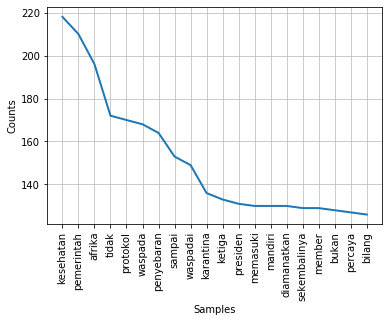

([('kesehatan', 218),
  ('pemerintah', 210),
  ('afrika', 196),
  ('tidak', 172),
  ('protokol', 170),
  ('waspada', 168),
  ('penyebaran', 164),
  ('sampai', 153),
  ('waspadai', 149),
  ('karantina', 136),
  ('ketiga', 133),
  ('presiden', 131),
  ('memasuki', 130),
  ('mandiri', 130),
  ('diamanatkan', 130),
  ('sekembalinya', 129),
  ('member', 129),
  ('bukan', 128),
  ('percaya', 127),
  ('bilang', 126)],
 ['wantankri',
  'dugaan',
  'semoga',
  'tidak',
  'menyebar',
  'indonesia',
  'protokol',
  'kesehatan',
  'taati',
  'anjuran',
  'pemerintah',
  'libur',
  'sekembalinya',
  'ketiga',
  'member',
  'memasuki',
  'karantina',
  'mandiri',
  'diamanatkan',
  'pemerintah',
  'kedata',
  'sasall',
  'pakar',
  'kesehatan',
  'elizabeth',
  'jane',
  'soepardi',
  'mengajak',
  'masyarakat',
  'waspada',
  'bisa',
  'wantankri',
  'dugaan',
  'semoga',
  'tidak',
  'menyebar',
  'indonesia',
  'protokol',
  'kesehatan',
  'taati',
  'anjuran',
  'pemerintah',
  'libur',
  'wanta

In [163]:
words_freq_distribution(df_semua_clean)

In [164]:
df_semua_clean_positif = pd.DataFrame(df_semua_clean[df_semua_clean['sentiment'] == 1]['clean_berita'].copy())
df_semua_clean_negatif = pd.DataFrame(df_semua_clean[df_semua_clean['sentiment'] == 0]['clean_berita'].copy())

kata-kata yang sering keluar dalam data sentiment positif maupun negatif:

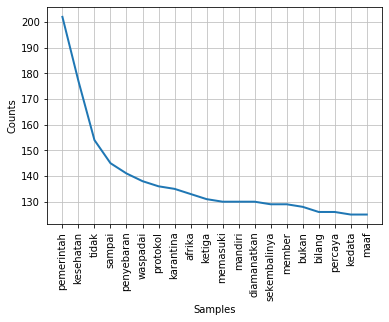

([('pemerintah', 202),
  ('kesehatan', 177),
  ('tidak', 154),
  ('sampai', 145),
  ('penyebaran', 141),
  ('waspadai', 138),
  ('protokol', 136),
  ('karantina', 135),
  ('afrika', 133),
  ('ketiga', 131),
  ('memasuki', 130),
  ('mandiri', 130),
  ('diamanatkan', 130),
  ('sekembalinya', 129),
  ('member', 129),
  ('bukan', 128),
  ('bilang', 126),
  ('percaya', 126),
  ('kedata', 125),
  ('maaf', 125)],
 ['wantankri',
  'dugaan',
  'semoga',
  'tidak',
  'menyebar',
  'indonesia',
  'protokol',
  'kesehatan',
  'taati',
  'anjuran',
  'pemerintah',
  'libur',
  'sekembalinya',
  'ketiga',
  'member',
  'memasuki',
  'karantina',
  'mandiri',
  'diamanatkan',
  'pemerintah',
  'kedata',
  'sasall',
  'pakar',
  'kesehatan',
  'elizabeth',
  'jane',
  'soepardi',
  'mengajak',
  'masyarakat',
  'waspada',
  'bisa',
  'wantankri',
  'dugaan',
  'semoga',
  'tidak',
  'menyebar',
  'indonesia',
  'protokol',
  'kesehatan',
  'taati',
  'anjuran',
  'pemerintah',
  'libur',
  'wantankri'

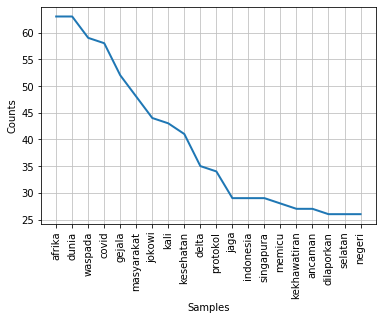

([('afrika', 63),
  ('dunia', 63),
  ('waspada', 59),
  ('covid', 58),
  ('gejala', 52),
  ('masyarakat', 48),
  ('jokowi', 44),
  ('kali', 43),
  ('kesehatan', 41),
  ('delta', 35),
  ('protokol', 34),
  ('jaga', 29),
  ('indonesia', 29),
  ('singapura', 29),
  ('memicu', 28),
  ('kekhawatiran', 27),
  ('ancaman', 27),
  ('dilaporkan', 26),
  ('selatan', 26),
  ('negeri', 26)],
 ['otoritas',
  'palestina',
  'mengirimkan',
  'sampel',
  'covid',
  'rumah',
  'sakit',
  'israel',
  'diuji',
  'terkait',
  'waspada',
  'afrika',
  'mari',
  'jaga',
  'protokol',
  'kesehatan',
  'protokol',
  'kesehatan',
  'tuntaskan',
  'pandemi',
  'diduga',
  'masuk',
  'menyebar',
  'indonesia',
  'diduga',
  'masuk',
  'menyebar',
  'indonesia',
  'id',
  'postingan',
  'media',
  'sosial',
  'membagikan',
  'daftar',
  'dugaan',
  'gejala',
  'menyiratkan',
  'gej',
  'ns',
  'waspada',
  'penyebaran',
  'afrika',
  'waspadai',
  'penyebaran',
  'afrika',
  'protokol',
  'kesehatan',
  'tuntaskan

In [165]:
display(words_freq_distribution(df_semua_clean_positif))
display(words_freq_distribution(df_semua_clean_negatif))

Nilai rata-rata: 0.19394512771996217
Standar deviasi: 1.1917571076404576


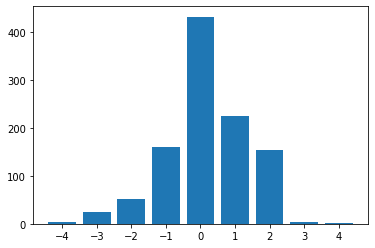

In [166]:
#lakukan analisis dan tarik kesimpulan dari Text analysis dan Sentiment Analysis
#masukkan analisis kalian pada sel berikut.

print ("Nilai rata-rata: "+str(np.mean(hasil)))
print ("Standar deviasi: "+str(np.std(hasil)))

labels, counts = np.unique(hasil, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

persebaran data cenderung berpusat di netral.

In [167]:
df_semua_clean.to_csv('data_semua_model_sentiment.csv',index=False)

# 5. Pembuatan model

In [168]:
df_semua_clean = pd.read_csv('data_semua_model_sentiment.csv')

In [169]:
df_semua_clean.dtypes

date                 object
isi                  object
clean_berita         object
sentiment             int64
clean_berita_word    object
dtype: object

Pembuatan model dengan Naive Bayes

In [170]:
#proses pembuatan model

vectorizer = TfidfVectorizer(max_features=2500)
model_g = GaussianNB()

In [172]:
v_data = vectorizer.fit_transform(df_semua_clean['clean_berita'].values.astype('U')).toarray()

X_train, X_test, y_train, y_test = train_test_split(v_data, df_semua_clean['sentiment'], test_size=0.2, random_state=18)
model_g.fit(X_train,y_train)


GaussianNB()

In [173]:
y_preds = model_g.predict(X_test)

print(confusion_matrix(y_test,y_preds))
print(classification_report(y_test,y_preds))
print('nilai akurasinya adalah ',accuracy_score(y_test,y_preds))

[[ 32   7]
 [ 32 141]]
              precision    recall  f1-score   support

           0       0.50      0.82      0.62        39
           1       0.95      0.82      0.88       173

    accuracy                           0.82       212
   macro avg       0.73      0.82      0.75       212
weighted avg       0.87      0.82      0.83       212

nilai akurasinya adalah  0.8160377358490566


nilai akurasinya terbilang bagus yaitu sebesar 0.81. 

Nilai recall tinggi.
Tetapi nilai precision dan f1-score ada yang dibawah 80.Ini bearti sebenarnya model yang kita buat kinerjanya tidak terlalu baik.

# DATA TEST

# 1. Scraping data

## 1.1 Scraping data from twitter

In [108]:
scrapper1 = tweetsGrabber()

In [109]:
#buat variabel authentikasi dan api

auth = tweepy.OAuthHandler(scrapper1.api_key, scrapper1.api_key_secret)
auth.set_access_token(scrapper1.access_token, scrapper1.access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit = True)

In [110]:
list_date=[]
list_tweet=[]

In [111]:
def user_timeline_scraper(username):
    tweets = tweepy.Cursor(api.search_tweets, q=username, lang="id",tweet_mode="extended",until ='2021-12-07').items(1000)
    for tweet in tweets:
        list_date.append(tweet.created_at)
        list_tweet.append(tweet.full_text) 

In [113]:
username = "semeru, bencana, jawa timur"
user_timeline_scraper(username)

In [162]:
d ={'date':list_date,'tweet':list_tweet}

df= pd.DataFrame(d)
df

date  \
0   2021-12-06 23:58:24+00:00   
1   2021-12-06 23:49:56+00:00   
2   2021-12-06 23:48:18+00:00   
3   2021-12-06 23:47:46+00:00   
4   2021-12-06 23:47:15+00:00   
..                        ...   
995 2021-12-06 09:41:21+00:00   
996 2021-12-06 09:41:18+00:00   
997 2021-12-06 09:41:15+00:00   
998 2021-12-06 09:41:01+00:00   
999 2021-12-06 09:40:47+00:00   

                                                 tweet  
0    Info Erupsi Gunung Semeru\n\nTurut berduka den...  
1    RT @detikcom: Sebanyak 2.004 warga mengungsi i...  
2    Segenap keluarga besar PSI Kota Yogyakarta tur...  
3    RT @__RismaWidiono_: Respons cepat ditunjukkan...  
4    Ketua PWNU Jawa Timur KH Marzuki Mustamar meng...  
..                                                 ...  
995  RT @soup_soup11: Kementerian BUMN dikomandoi E...  
996  RT @_0l4h: Poros Kalimantan – Kementerian BUMN...  
997  RT @LokoJoyo81: Kementerian BUMN bergerak cepa...  
998  RT @SydneyX5w: Kementerian BUMN bergerak cepat...  
999  RT @RatuCebong: Atas bencana erupsi Gunung Sem...  

[1000 rows x 2 columns]

In [163]:
df.to_csv('data_twitter.csv',index=False)

## 1.2 Scrapping data from berita

In [114]:
#alamat1

alamat1 = "https://ekonomi.bisnis.com/read/20211204/98/1473816/gunung-semeru-meletus-ini-dampak-ke-operasional-penerbangan"
html = urlopen(alamat1)
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36'
headers = {'User-Agent' : user_agent,'Accept':'image/avif,image/webp,image/apng,image/svg+xml,image/*,*/*;q=0.8'}
data_request = Request(alamat1, headers = headers)
response = urlopen(data_request)
soup = bs(response,'html.parser')
berita = soup.find('div', {'class':'col-sm-10'})
isi_berita = berita.find_all('p')
berita_list = [berita.get_text().strip() for berita in isi_berita]
df_berita1 = pd.DataFrame(berita_list, columns = ['isi'])
df_berita1['date'] = "2021-12-04"
df_berita1 = df_berita1[:7]
df_berita1.head()

isi        date
0  Bisnis.com, JAKARTA - AirNav Indonesia memberi...  2021-12-04
1  Sekretaris Perusahaan AirNav Indonesia Rosedi ...  2021-12-04
2  "Sampai berita ini disampaikan (4/12/2021) puk...  2021-12-04
3  Dia menjelaskan Ashtam yang dirilis pertama, N...  2021-12-04
4  Kedua, No. Ashtam 2170, ketinggian abu vulkani...  2021-12-04

In [102]:
#alamat2

alamat2 = "https://jatengprov.go.id/publik/semeru-erupsi-ganjar-dan-santri-ponpes-tawangmangu-gelar-doa-bersama/"
html = urlopen(alamat2)
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36'
headers = {'User-Agent' : user_agent,'Accept':'image/avif,image/webp,image/apng,image/svg+xml,image/*,*/*;q=0.8'}
data_request = Request(alamat2, headers = headers)
response = urlopen(data_request)
soup = bs(response,'html.parser')
berita = soup.find('div', {'class':'news-single-content'})
isi_berita = berita.find_all('div')
berita_list = [berita.get_text().strip() for berita in isi_berita]
df_berita2 = pd.DataFrame(berita_list, columns = ['isi'])
df_berita2['date'] = "2021-12-04"
df_berita2.head()

isi        date
0  KARANGANYAR – Gunung Semeru meletus pada hari ...  2021-12-04
1                                                     2021-12-04
2  Doa untuk warga sekitar Semeru menggema dari s...  2021-12-04
3                                                     2021-12-04
4  Doa dipimpin Ketua Yayasan Pondok Pesantren Is...  2021-12-04

In [104]:
df_berita2 = df_berita2.drop([1,3,5,7,9,11,13,15,16,17,18,19,20,21,22]).reset_index(drop=True)
df_berita2

isi        date
0  KARANGANYAR – Gunung Semeru meletus pada hari ...  2021-12-04
1  Doa untuk warga sekitar Semeru menggema dari s...  2021-12-04
2  Doa dipimpin Ketua Yayasan Pondok Pesantren Is...  2021-12-04
3  “Ya Allah hari ini Gunung Semeru meletus. Muda...  2021-12-04
4  Sementara, Gubernur Ganjar mengatakan, dia ber...  2021-12-04
5  “Insyaallah kami siap membantu. Tadi bersama p...  2021-12-04
6  Disinggung apakah dampak letusan Gunung Semeru...  2021-12-04
7  “Sampai saat ini belum, teman-teman BPBD sedan...  2021-12-04

In [94]:
#alamat3

alamat3 = "https://news.detik.com/berita-jawa-timur/d-5841231/peralatan-mandi-hingga-selimut-dikirim-ke-korban-terdampak-erupsi-semeru"
html = urlopen(alamat3)
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36'
headers = {'User-Agent' : user_agent,'Accept':'image/avif,image/webp,image/apng,image/svg+xml,image/*,*/*;q=0.8'}
data_request = Request(alamat3, headers = headers)
response = urlopen(data_request)
soup = bs(response,'html.parser')
berita = soup.find('div', {'class':'detail__body-text itp_bodycontent'})
isi_berita = berita.find_all('p')
berita_list = [berita.get_text().strip() for berita in isi_berita]
df_berita3 = pd.DataFrame(berita_list, columns = ['isi'])
df_berita3['date'] = "2021-12-05"
df_berita3.head()

isi        date
0  BPBD Lamongan mengirim logistik dan personel u...  2021-12-05
1  "Pagi ini kami mengirim 11 petugas BPBD, 4 rel...  2021-12-05
2  Logistik yang dikirim ke Lumajang di antaranya...  2021-12-05
3  "Mengingat saat ini masih dalam kondisi pandem...  2021-12-05
4  "Personel dan relawan dari Lamongan ini akan b...  2021-12-05

In [101]:
df_berita3 = df_berita3[:10]

In [120]:
df_gabung = pd.concat([df_berita1,df_berita2,df_berita3])
df_gabung = df_gabung[['date','isi']]
df_gabung.head()

date                                                isi
0  2021-12-04  Bisnis.com, JAKARTA - AirNav Indonesia memberi...
1  2021-12-04  Sekretaris Perusahaan AirNav Indonesia Rosedi ...
2  2021-12-04  "Sampai berita ini disampaikan (4/12/2021) puk...
3  2021-12-04  Dia menjelaskan Ashtam yang dirilis pertama, N...
4  2021-12-04  Kedua, No. Ashtam 2170, ketinggian abu vulkani...

In [122]:
df_gabung.to_csv('data_berita.csv',index=False)

# 2. Cleaning data

## 2.1 Cleaning data twitter

In [174]:
df_raw = pd.read_csv('data_twitter.csv')

In [175]:
df_raw['clean_tweet']=0

In [176]:
for index in range (len(df_raw)):
    df_raw.iloc[index,2] = proses(df_raw.iloc[index,1])
    
df_raw

date  \
0    2021-12-06 23:58:24+00:00   
1    2021-12-06 23:49:56+00:00   
2    2021-12-06 23:48:18+00:00   
3    2021-12-06 23:47:46+00:00   
4    2021-12-06 23:47:15+00:00   
..                         ...   
995  2021-12-06 09:41:21+00:00   
996  2021-12-06 09:41:18+00:00   
997  2021-12-06 09:41:15+00:00   
998  2021-12-06 09:41:01+00:00   
999  2021-12-06 09:40:47+00:00   

                                                 tweet  \
0    Info Erupsi Gunung Semeru\n\nTurut berduka den...   
1    RT @detikcom: Sebanyak 2.004 warga mengungsi i...   
2    Segenap keluarga besar PSI Kota Yogyakarta tur...   
3    RT @__RismaWidiono_: Respons cepat ditunjukkan...   
4    Ketua PWNU Jawa Timur KH Marzuki Mustamar meng...   
..                                                 ...   
995  RT @soup_soup11: Kementerian BUMN dikomandoi E...   
996  RT @_0l4h: Poros Kalimantan – Kementerian BUMN...   
997  RT @LokoJoyo81: Kementerian BUMN bergerak cepa...   
998  RT @SydneyX5w: Kementerian BUMN bergerak cepat...   
999  RT @RatuCebong: Atas bencana erupsi Gunung Sem...   

                                           clean_tweet  
0    info erupsi berduka erupsi banjir lahar kabupa...  
1    warga mengungsi imbas erupsi lumajang tersebar...  
2    segenap keluarga psi kota yogyakarta berduka p...  
3    rismawidiono respons cepat pemprov jawa tengah...  
4    ketua pwnu kh marzuki mustamar mengajak masyar...  
..                                                 ...  
995  soup kementerian badan usaha milik negara diko...  
996  malah poros kalimantan kementerian badan usaha...  
997  kementerian badan usaha milik negara bergerak ...  
998  kementerian badan usaha milik negara bergerak ...  
999  erupsi langsung berkoordinasi badan penanggula...  

[1000 rows x 3 columns]

In [177]:
df_raw['date'] = pd.to_datetime(df_raw['date'])

In [178]:
df_raw.dtypes

date           datetime64[ns, UTC]
tweet                       object
clean_tweet                 object
dtype: object

In [179]:
df_waktu = pd.DataFrame(df_raw.resample('H', on='date').clean_tweet.count().reset_index())
df_waktu

date  clean_tweet
0  2021-12-06 09:00:00+00:00          113
1  2021-12-06 10:00:00+00:00          169
2  2021-12-06 11:00:00+00:00          173
3  2021-12-06 12:00:00+00:00          185
4  2021-12-06 13:00:00+00:00          128
5  2021-12-06 14:00:00+00:00          100
6  2021-12-06 15:00:00+00:00           42
7  2021-12-06 16:00:00+00:00           19
8  2021-12-06 17:00:00+00:00           14
9  2021-12-06 18:00:00+00:00           11
10 2021-12-06 19:00:00+00:00            6
11 2021-12-06 20:00:00+00:00            6
12 2021-12-06 21:00:00+00:00            7
13 2021-12-06 22:00:00+00:00            7
14 2021-12-06 23:00:00+00:00           20

Paling banyak pengguna twitter memposting tweet di jam 9 hingga 14

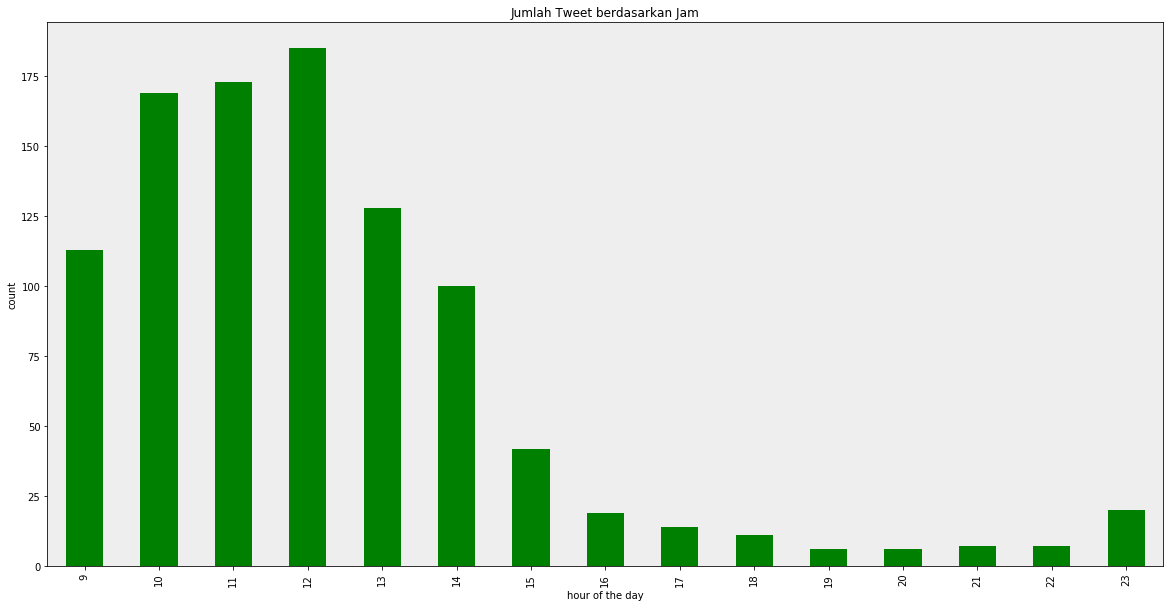

In [180]:
def visualize():

    plt.figure(figsize=(20, 10))
    ax = (df_raw['clean_tweet'].groupby(df_raw['date'].dt.hour).count()).plot(kind="bar", color='g')
    ax.set_facecolor('#eeeeee')
    ax.set_xlabel("hour of the day")
    ax.set_ylabel("count")
    ax.set_title('Jumlah Tweet berdasarkan Jam')
    plt.show()
    
visualize()

## 2.2 Cleaning data berita

In [181]:
df_raw1 = pd.read_csv('data_berita.csv')
df_raw1.head()

date                                                isi
0  2021-12-04  Bisnis.com, JAKARTA - AirNav Indonesia memberi...
1  2021-12-04  Sekretaris Perusahaan AirNav Indonesia Rosedi ...
2  2021-12-04  "Sampai berita ini disampaikan (4/12/2021) puk...
3  2021-12-04  Dia menjelaskan Ashtam yang dirilis pertama, N...
4  2021-12-04  Kedua, No. Ashtam 2170, ketinggian abu vulkani...

In [182]:
df_raw1['clean_berita']=0

In [183]:
for index in range (len(df_raw1)):
    df_raw1.iloc[index,2] = proses(df_raw1.iloc[index,1])
    
df_raw1

date                                                isi  \
0   2021-12-04  Bisnis.com, JAKARTA - AirNav Indonesia memberi...   
1   2021-12-04  Sekretaris Perusahaan AirNav Indonesia Rosedi ...   
2   2021-12-04  "Sampai berita ini disampaikan (4/12/2021) puk...   
3   2021-12-04  Dia menjelaskan Ashtam yang dirilis pertama, N...   
4   2021-12-04  Kedua, No. Ashtam 2170, ketinggian abu vulkani...   
5   2021-12-04  Dia menuturkan hasil pilot report terhadap Pes...   
6   2021-12-04  AirNav Indonesia terus berkoordinasi dengan st...   
7   2021-12-04  KARANGANYAR – Gunung Semeru meletus pada hari ...   
8   2021-12-04  Doa untuk warga sekitar Semeru menggema dari s...   
9   2021-12-04  Doa dipimpin Ketua Yayasan Pondok Pesantren Is...   
10  2021-12-04  “Ya Allah hari ini Gunung Semeru meletus. Muda...   
11  2021-12-04  Sementara, Gubernur Ganjar mengatakan, dia ber...   
12  2021-12-04  “Insyaallah kami siap membantu. Tadi bersama p...   
13  2021-12-04  Disinggung apakah dampak letusan Gunung Semeru...   
14  2021-12-04  “Sampai saat ini belum, teman-teman BPBD sedan...   
15  2021-12-05  BPBD Lamongan mengirim logistik dan personel u...   
16  2021-12-05  "Pagi ini kami mengirim 11 petugas BPBD, 4 rel...   
17  2021-12-05  Logistik yang dikirim ke Lumajang di antaranya...   
18  2021-12-05  "Mengingat saat ini masih dalam kondisi pandem...   
19  2021-12-05  "Personel dan relawan dari Lamongan ini akan b...   
20  2021-12-05  Personel yang ditugaskan ke Lumajang juga teta...   
21  2021-12-05  "Semua akan bergerak ke lokasi bencana dengan ...   
22  2021-12-05  Sebelumnya, Gunung Semeru erupsi sekitar pukul...   
23  2021-12-05  Wakil Bupati Lumajang, Indah Amperawati Masdar...   
24  2021-12-05  Mereka dirawat di Puskesmas dan RS untuk peraw...   

                                         clean_berita  
0   bisnis com jakarta airnav indonesia laporan te...  
1   sekretaris perusahaan airnav indonesia rosedi ...  
2   berita wib tidak dampak signifkan aktivitas er...  
3   ashtam dirilis no ashtam status red alert keti...  
4   no ashtam ketinggian abu vulkanik permukaan ta...  
5   hasil pilot report pesawat wings air melintas ...  
6   airnav indonesia berkoordinasi stakeholder pen...  
7   karanganyar meletus sabtu letusan api terletak...  
8   doa warga menggema masyarakat indonesia gubern...  
9   doa dipimpin ketua yayasan pondok pesantren is...  
10  katanya allah meletus mudah mudahan bukan tand...  
11  gubernur ganjar masyarakat jawa tengah santri ...  
12  insyaallah membantu santri mendoakan mudah mud...  
13  disinggung dampak letusan jawa tengah ganjar m...  
14  teman teman badan penanggulangan bencana daera...  
15  badan penanggulangan bencana daerah lamongan m...  
16  pagi mengirim petugas badan penanggulangan ben...  
17  logistik dikirim lumajang selimut paket sandan...  
18  kondisi pandemi covid badan penanggulangan ben...  
19  personel relawan lamongan berkoordinasi badan ...  
20  personel ditugaskan lumajang diimbau menjaga p...  
21  bergerak lokasi koordinasi dibawah badan penan...  
22  erupsi wib warga berlarian menyelamatkan desa ...  
23  wakil bupati lumajang indah amperawati masdar ...  
24  dirawat puskesmas rs perawatan intensif korban...

# 3. Gabungkan data test

In [184]:
df_raw.head()

date  \
0 2021-12-06 23:58:24+00:00   
1 2021-12-06 23:49:56+00:00   
2 2021-12-06 23:48:18+00:00   
3 2021-12-06 23:47:46+00:00   
4 2021-12-06 23:47:15+00:00   

                                               tweet  \
0  Info Erupsi Gunung Semeru\n\nTurut berduka den...   
1  RT @detikcom: Sebanyak 2.004 warga mengungsi i...   
2  Segenap keluarga besar PSI Kota Yogyakarta tur...   
3  RT @__RismaWidiono_: Respons cepat ditunjukkan...   
4  Ketua PWNU Jawa Timur KH Marzuki Mustamar meng...   

                                         clean_tweet  
0  info erupsi berduka erupsi banjir lahar kabupa...  
1  warga mengungsi imbas erupsi lumajang tersebar...  
2  segenap keluarga psi kota yogyakarta berduka p...  
3  rismawidiono respons cepat pemprov jawa tengah...  
4  ketua pwnu kh marzuki mustamar mengajak masyar...

In [185]:
df_raw.columns =['date','isi','clean_berita']

In [186]:
df_semua =  pd.concat([df_raw,df_raw1])
df_semua = df_semua.drop_duplicates()
df_semua.to_csv('data_semua.csv',index=False)

In [187]:
df_semua

date  \
0   2021-12-06 23:58:24+00:00   
1   2021-12-06 23:49:56+00:00   
2   2021-12-06 23:48:18+00:00   
3   2021-12-06 23:47:46+00:00   
4   2021-12-06 23:47:15+00:00   
..                        ...   
20                 2021-12-05   
21                 2021-12-05   
22                 2021-12-05   
23                 2021-12-05   
24                 2021-12-05   

                                                  isi  \
0   Info Erupsi Gunung Semeru\n\nTurut berduka den...   
1   RT @detikcom: Sebanyak 2.004 warga mengungsi i...   
2   Segenap keluarga besar PSI Kota Yogyakarta tur...   
3   RT @__RismaWidiono_: Respons cepat ditunjukkan...   
4   Ketua PWNU Jawa Timur KH Marzuki Mustamar meng...   
..                                                ...   
20  Personel yang ditugaskan ke Lumajang juga teta...   
21  "Semua akan bergerak ke lokasi bencana dengan ...   
22  Sebelumnya, Gunung Semeru erupsi sekitar pukul...   
23  Wakil Bupati Lumajang, Indah Amperawati Masdar...   
24  Mereka dirawat di Puskesmas dan RS untuk peraw...   

                                         clean_berita  
0   info erupsi berduka erupsi banjir lahar kabupa...  
1   warga mengungsi imbas erupsi lumajang tersebar...  
2   segenap keluarga psi kota yogyakarta berduka p...  
3   rismawidiono respons cepat pemprov jawa tengah...  
4   ketua pwnu kh marzuki mustamar mengajak masyar...  
..                                                ...  
20  personel ditugaskan lumajang diimbau menjaga p...  
21  bergerak lokasi koordinasi dibawah badan penan...  
22  erupsi wib warga berlarian menyelamatkan desa ...  
23  wakil bupati lumajang indah amperawati masdar ...  
24  dirawat puskesmas rs perawatan intensif korban...  

[1025 rows x 3 columns]

In [188]:
df_semua.to_csv('data_test_semua.csv',index=False)

# 4. Analisa data

In [189]:
df_semua = pd.read_csv('data_test_semua.csv')

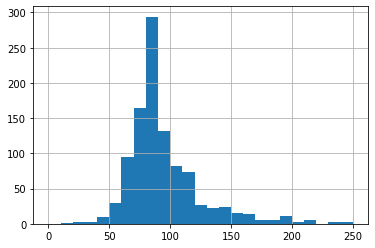

In [190]:
char_freq_distribution(df_semua)

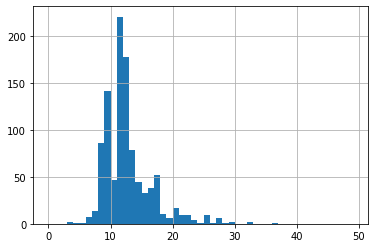

In [191]:
word_len_freq_distribution(df_semua)

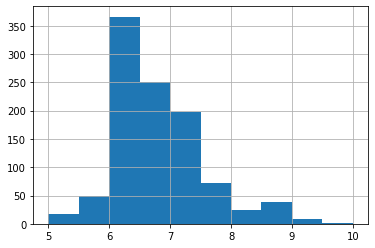

In [192]:
mean_words_freq_distribution(df_semua)

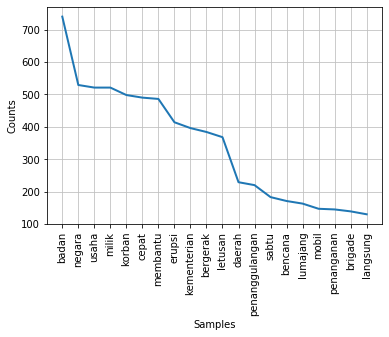

([('badan', 740),
  ('negara', 529),
  ('usaha', 521),
  ('milik', 521),
  ('korban', 498),
  ('cepat', 490),
  ('membantu', 486),
  ('erupsi', 414),
  ('kementerian', 396),
  ('bergerak', 384),
  ('letusan', 368),
  ('daerah', 229),
  ('penanggulangan', 220),
  ('sabtu', 183),
  ('bencana', 171),
  ('lumajang', 163),
  ('mobil', 147),
  ('penanganan', 145),
  ('brigade', 139),
  ('langsung', 130)],
 ['info',
  'erupsi',
  'berduka',
  'erupsi',
  'banjir',
  'lahar',
  'kabupaten',
  'lumajang',
  'fb',
  'sdamada',
  'ig',
  'sdamada',
  'prayforsemeru',
  'sdamada',
  'sdmuhammadiyahsidoarjo',
  'warga',
  'mengungsi',
  'imbas',
  'erupsi',
  'lumajang',
  'tersebar',
  'titik',
  'pengungsian',
  'tidak',
  'segenap',
  'keluarga',
  'psi',
  'kota',
  'yogyakarta',
  'berduka',
  'peristiwa',
  'alam',
  'erupsi',
  'doa',
  'korban',
  'masyarakat',
  'terdampak',
  'prayforsemeru',
  'prayforlumajang',
  'rismawidiono',
  'respons',
  'cepat',
  'pemprov',
  'jawa',
  'tengah',

In [193]:
words_freq_distribution(df_semua)

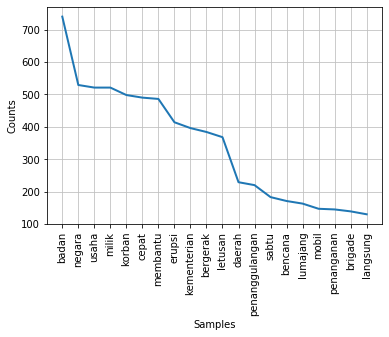

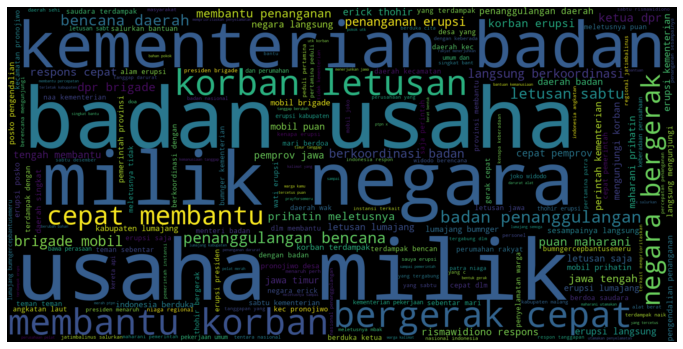

In [194]:
most_common_word, tweets = words_freq_distribution(df_semua)
wordcloud_visualization(" ".join(tweets))

In [195]:
bigram_freq_distribution(df_semua)

(badan, usaha)             521
(usaha, milik)             521
(milik, negara)            521
(kementerian, badan)       377
(bergerak, cepat)          373
(membantu, korban)         372
(korban, letusan)          363
(cepat, membantu)          351
(negara, bergerak)         347
(badan, penanggulangan)    206
dtype: int64

# 5. Topik Modelling

In [196]:
data_tweet = [tweet.split() for tweet in df_semua["clean_berita"]]

In [197]:
dictionary = corpora.Dictionary(data_tweet)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_tweet]

In [198]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_matrix, 
    num_topics=5, 
    id2word = dictionary, 
    passes=50
    )

In [199]:
from pprint import pprint
pprint(ldamodel.print_topics())

[(0,
  '0.094*"lumajang" + 0.048*"bantuan" + 0.039*"personel" + 0.038*"erupsi" + '
  '0.026*"masyarakat" + 0.021*"bumnger" + 0.017*"logistik" + 0.017*"tidak" + '
  '0.016*"korban" + 0.015*"terdampak"'),
 (1,
  '0.066*"penanganan" + 0.065*"membantu" + 0.065*"erupsi" + 0.052*"tengah" + '
  '0.052*"jawa" + 0.046*"cepat" + 0.043*"respons" + 0.038*"saja" + '
  '0.030*"pemprov" + 0.029*"rismawidiono"'),
 (2,
  '0.059*"mobil" + 0.057*"brigade" + 0.042*"puan" + 0.040*"ketua" + '
  '0.037*"meletusnya" + 0.037*"prihatin" + 0.036*"dpr" + 0.035*"maharani" + '
  '0.029*"indonesia" + 0.028*"erupsi"'),
 (3,
  '0.043*"daerah" + 0.041*"penanggulangan" + 0.038*"badan" + 0.034*"bencana" + '
  '0.021*"desa" + 0.018*"terdampak" + 0.011*"pronojiwo" + 0.010*"wib" + '
  '0.010*"ganjar" + 0.010*"katanya"'),
 (4,
  '0.099*"badan" + 0.079*"negara" + 0.078*"milik" + 0.078*"usaha" + '
  '0.062*"bergerak" + 0.061*"korban" + 0.059*"cepat" + 0.058*"letusan" + '
  '0.057*"kementerian" + 0.056*"membantu"')]


In [200]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_tweet, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.38688698631364604


In [201]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_tweet, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [202]:
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [1:27:26<00:00,  9.72s/it]


In [204]:
df_tuning_result = pd.read_csv('lda_tuning_results.csv')
df_tuning_result.sort_values(by = ['Coherence'], ascending = False).head(10)
df_tuning_result

Validation_Set  Topics       Alpha                Beta  Coherence
0       75% Corpus       2        0.01                0.01   0.270377
1       75% Corpus       2        0.01                0.31   0.262670
2       75% Corpus       2        0.01                0.61   0.264501
3       75% Corpus       2        0.01  0.9099999999999999   0.264501
4       75% Corpus       2        0.01           symmetric   0.262670
..             ...     ...         ...                 ...        ...
535    100% Corpus      10  asymmetric                0.01   0.434893
536    100% Corpus      10  asymmetric                0.31   0.369701
537    100% Corpus      10  asymmetric                0.61   0.393574
538    100% Corpus      10  asymmetric  0.9099999999999999   0.372486
539    100% Corpus      10  asymmetric           symmetric   0.391308

[540 rows x 5 columns]

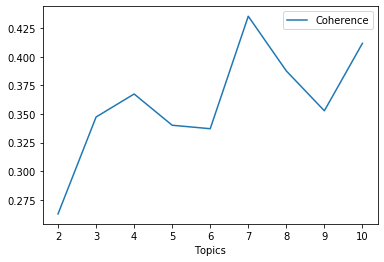

In [205]:
df_plot = df_tuning_result[(df_tuning_result.Alpha == "0.01") & (df_tuning_result.Beta == "0.31") & (df_tuning_result.Validation_Set == "75% Corpus")].copy()
df_plot.plot(x='Topics', y = "Coherence", kind="line")

In [232]:
df_plot_2 = df_tuning_result[(df_tuning_result.Topics == 3) & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot_2.sort_values(by="Coherence", ascending=False)

Validation_Set  Topics               Alpha                Beta  Coherence
305    100% Corpus       3                0.31                0.01   0.395042
315    100% Corpus       3  0.9099999999999999                0.01   0.385060
316    100% Corpus       3  0.9099999999999999                0.31   0.385060
319    100% Corpus       3  0.9099999999999999           symmetric   0.385060
317    100% Corpus       3  0.9099999999999999                0.61   0.385060
314    100% Corpus       3                0.61           symmetric   0.368382
313    100% Corpus       3                0.61  0.9099999999999999   0.362909
326    100% Corpus       3          asymmetric                0.31   0.360914
300    100% Corpus       3                0.01                0.01   0.360135
310    100% Corpus       3                0.61                0.01   0.359647
309    100% Corpus       3                0.31           symmetric   0.359319
311    100% Corpus       3                0.61                0.31   0.358362
312    100% Corpus       3                0.61                0.61   0.357016
325    100% Corpus       3          asymmetric                0.01   0.356663
329    100% Corpus       3          asymmetric           symmetric   0.355133
318    100% Corpus       3  0.9099999999999999  0.9099999999999999   0.354210
306    100% Corpus       3                0.31                0.31   0.353860
304    100% Corpus       3                0.01           symmetric   0.353688
301    100% Corpus       3                0.01                0.31   0.353688
303    100% Corpus       3                0.01  0.9099999999999999   0.352459
307    100% Corpus       3                0.31                0.61   0.351336
322    100% Corpus       3           symmetric                0.61   0.351336
323    100% Corpus       3           symmetric  0.9099999999999999   0.351336
308    100% Corpus       3                0.31  0.9099999999999999   0.351336
324    100% Corpus       3           symmetric           symmetric   0.348712
320    100% Corpus       3           symmetric                0.01   0.346558
327    100% Corpus       3          asymmetric                0.61   0.343683
328    100% Corpus       3          asymmetric  0.9099999999999999   0.337469
302    100% Corpus       3                0.01                0.61   0.323005
321    100% Corpus       3           symmetric                0.31   0.321825

In [233]:
lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=3, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.01)
pprint(lda_model.print_topics())

[(0,
  '0.112*"badan" + 0.081*"daerah" + 0.077*"penanggulangan" + 0.060*"bencana" + '
  '0.057*"erupsi" + 0.040*"berkoordinasi" + 0.036*"negara" + 0.033*"usaha" + '
  '0.033*"milik" + 0.033*"langsung"'),
 (1,
  '0.081*"membantu" + 0.081*"cepat" + 0.072*"milik" + 0.072*"usaha" + '
  '0.071*"negara" + 0.070*"badan" + 0.069*"korban" + 0.068*"bergerak" + '
  '0.064*"letusan" + 0.062*"kementerian"'),
 (2,
  '0.060*"mobil" + 0.057*"brigade" + 0.039*"puan" + 0.038*"ketua" + '
  '0.038*"erupsi" + 0.037*"prihatin" + 0.037*"dpr" + 0.037*"meletusnya" + '
  '0.031*"maharani" + 0.025*"indonesia"')]


In [234]:
for i in range(3):
    col_name = 'news_topic_'+str(i)
    df_semua[col_name] = 0

In [235]:
df_semua

date  \
0     2021-12-06 23:58:24+00:00   
1     2021-12-06 23:49:56+00:00   
2     2021-12-06 23:48:18+00:00   
3     2021-12-06 23:47:46+00:00   
4     2021-12-06 23:47:15+00:00   
...                         ...   
1020                 2021-12-05   
1021                 2021-12-05   
1022                 2021-12-05   
1023                 2021-12-05   
1024                 2021-12-05   

                                                    isi  \
0     Info Erupsi Gunung Semeru\n\nTurut berduka den...   
1     RT @detikcom: Sebanyak 2.004 warga mengungsi i...   
2     Segenap keluarga besar PSI Kota Yogyakarta tur...   
3     RT @__RismaWidiono_: Respons cepat ditunjukkan...   
4     Ketua PWNU Jawa Timur KH Marzuki Mustamar meng...   
...                                                 ...   
1020  Personel yang ditugaskan ke Lumajang juga teta...   
1021  "Semua akan bergerak ke lokasi bencana dengan ...   
1022  Sebelumnya, Gunung Semeru erupsi sekitar pukul...   
1023  Wakil Bupati Lumajang, Indah Amperawati Masdar...   
1024  Mereka dirawat di Puskesmas dan RS untuk peraw...   

                                           clean_berita  \
0     info erupsi berduka erupsi banjir lahar kabupa...   
1     warga mengungsi imbas erupsi lumajang tersebar...   
2     segenap keluarga psi kota yogyakarta berduka p...   
3     rismawidiono respons cepat pemprov jawa tengah...   
4     ketua pwnu kh marzuki mustamar mengajak masyar...   
...                                                 ...   
1020  personel ditugaskan lumajang diimbau menjaga p...   
1021  bergerak lokasi koordinasi dibawah badan penan...   
1022  erupsi wib warga berlarian menyelamatkan desa ...   
1023  wakil bupati lumajang indah amperawati masdar ...   
1024  dirawat puskesmas rs perawatan intensif korban...   

                                      clean_berita_word  sentiment  \
0     [info, erupsi, berduka, erupsi, banjir, lahar,...          1   
1     [warga, mengungsi, imbas, erupsi, lumajang, te...          0   
2     [segenap, keluarga, psi, kota, yogyakarta, ber...          1   
3     [rismawidiono, respons, cepat, pemprov, jawa, ...          0   
4     [ketua, pwnu, kh, marzuki, mustamar, mengajak,...          1   
...                                                 ...        ...   
1020  [personel, ditugaskan, lumajang, diimbau, menj...          0   
1021  [bergerak, lokasi, koordinasi, dibawah, badan,...          1   
1022  [erupsi, wib, warga, berlarian, menyelamatkan,...          1   
1023  [wakil, bupati, lumajang, indah, amperawati, m...          0   
1024  [dirawat, puskesmas, rs, perawatan, intensif, ...          1   

      news_topic_0  news_topic_1  news_topic_2  
0                0             0             0  
1                0             0             0  
2                0             0             0  
3                0             0             0  
4                0             0             0  
...            ...           ...           ...  
1020             0             0             0  
1021             0             0             0  
1022             0             0             0  
1023             0             0             0  
1024             0             0             0  

[1025 rows x 8 columns]

In [236]:
for row_index, row in df_semua.iterrows():
    row = row.copy()
    new_doc = dictionary.doc2bow(word_tokenize(row['clean_berita']))
    print(new_doc)
    lda_result = lda_model[new_doc]
    for tpc in lda_result:
        col_name= 'news_topic_'+(str(tpc[0]).strip())
        print(row_index,col_name,tpc[1])
        df_semua.loc[row_index,col_name] = float(tpc[1])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1)]
0 news_topic_0 0.020050328
0 news_topic_1 0.019630974
0 news_topic_2 0.96031874
[(2, 1), (8, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]
1 news_topic_0 0.92734426
1 news_topic_1 0.031958822
1 news_topic_2 0.040696915
[(1, 1), (2, 1), (9, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)]
2 news_topic_0 0.020060603
2 news_topic_1 0.020248407
2 news_topic_2 0.959691
[(2, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)]
3 news_topic_0 0.033803385
3 news_topic_1 0.93340707
3 news_topic_2 0.03278958
[(2, 1), (18, 1), (22, 2), (24, 1), (33, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)]
4 news_topic_0 0.5363026
4 news_topic_1 0.119729936
4 news_topic_2 0.3439674
[(2, 1), (22, 1), (35, 1), (53, 1), (54, 1

67 news_topic_2 0.098907895
[(75, 1), (98, 1), (116, 1), (117, 1), (119, 1), (122, 2), (124, 1), (162, 1), (188, 1), (191, 1), (226, 1), (245, 1), (246, 1), (248, 1), (249, 1), (250, 1), (251, 1), (252, 1), (253, 1), (254, 1), (255, 1)]
68 news_topic_0 0.4718645
68 news_topic_1 0.01366551
68 news_topic_2 0.51447004
[(2, 1), (22, 1), (35, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)]
69 news_topic_0 0.042759087
69 news_topic_1 0.037960667
69 news_topic_2 0.9192803
[(2, 1), (22, 1), (35, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)]
70 news_topic_0 0.04278818
70 news_topic_1 0.037961002
70 news_topic_2 0.91925085
[(2, 1), (22, 1), (35, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)]
71 news_topic_0 0.042758778
71 news_topic_1 0.037960667
71 news_topic_2 0.9192805
[(42, 1), (140, 1), (147, 1), (155, 1), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1)]
72 news_topic_0 0.025985198
72 news_topic_1 0.026656102
72 news_topic_2 0.94735867
[(2, 1), (22, 1), (35, 1), (

[(1, 1), (2, 1), (8, 1), (21, 1), (28, 1), (117, 1), (330, 1), (331, 1)]
114 news_topic_0 0.03580991
114 news_topic_1 0.03516036
114 news_topic_2 0.92902976
[(98, 1), (102, 1), (103, 1), (104, 1), (117, 1), (179, 2), (190, 1), (211, 1), (213, 1), (215, 1), (216, 1), (217, 1), (218, 1), (219, 1), (220, 1)]
115 news_topic_0 0.19443949
115 news_topic_1 0.78441644
115 news_topic_2 0.021144072
[(2, 1), (98, 3), (100, 1), (102, 1), (103, 1), (104, 1), (188, 1), (189, 1), (190, 2), (191, 2), (212, 1), (213, 1), (214, 1)]
116 news_topic_0 0.96290416
116 news_topic_1 0.019730726
116 news_topic_2 0.017365161
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (332, 1)]
117 news_topic_0 0.024809917
117 news_topic_1 0.9509887
117 news_topic_2 0.024201393
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
118 news_topic_0 0.02695054
118 news_topic_1 0.94695115
118 news_topic_2 0.02609833
[(2, 

[(2, 1), (53, 1), (98, 2), (102, 1), (103, 1), (104, 1), (188, 1), (189, 1), (190, 1), (191, 1), (193, 1), (408, 1)]
174 news_topic_0 0.9533113
174 news_topic_1 0.024270007
174 news_topic_2 0.022418665
[(22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (211, 1), (286, 1), (289, 1), (409, 1)]
175 news_topic_0 0.021816615
175 news_topic_1 0.9573642
175 news_topic_2 0.02081918
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
176 news_topic_0 0.026949447
176 news_topic_1 0.94695216
176 news_topic_2 0.02609833
[(2, 1), (22, 1), (31, 1), (98, 2), (99, 1), (102, 1), (103, 1), (104, 1), (190, 1), (191, 1), (286, 1), (289, 1), (408, 1)]
177 news_topic_0 0.49570382
177 news_topic_1 0.48321804
177 news_topic_2 0.021078134
[(22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (162, 1), (410, 1)]
178 news_topic_0 0.0247805
178 news_topic_1 0.94942385
178 new

225 news_topic_0 0.024823828
225 news_topic_1 0.95112604
225 news_topic_2 0.024050148
[(22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (368, 1)]
226 news_topic_0 0.026949802
226 news_topic_1 0.9469765
226 news_topic_2 0.026073724
[(2, 1), (8, 1), (32, 1), (98, 1), (102, 1), (103, 1), (104, 1), (114, 1), (147, 1), (167, 1), (217, 1), (225, 1), (344, 1), (440, 1), (441, 1)]
227 news_topic_0 0.8658764
227 news_topic_1 0.023268621
227 news_topic_2 0.11085498
[(2, 1), (22, 1), (29, 1), (31, 1), (33, 1), (99, 1), (150, 1), (286, 1), (289, 1)]
228 news_topic_0 0.30470398
228 news_topic_1 0.6626203
228 news_topic_2 0.032675736
[(22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (333, 1)]
229 news_topic_0 0.026951216
229 news_topic_1 0.9469751
229 news_topic_2 0.026073702
[(29, 1), (98, 2), (102, 1), (103, 1), (104, 1), (179, 1), (188, 1), (190, 2), (191, 1), (199, 1), (212, 1), (216, 1), (217, 1), (356, 

276 news_topic_1 0.9505363
276 news_topic_2 0.024071038
[(2, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)]
277 news_topic_0 0.03379957
277 news_topic_1 0.9334107
277 news_topic_2 0.032789722
[(2, 1), (88, 1), (207, 1), (208, 1), (209, 1), (210, 1)]
278 news_topic_0 0.7601562
278 news_topic_1 0.1938321
278 news_topic_2 0.04601167
[(16, 1), (31, 1), (32, 1), (33, 1), (35, 1), (100, 1), (105, 1), (106, 1), (107, 1), (108, 1), (110, 1), (111, 1), (112, 1), (113, 1), (114, 1), (115, 1), (146, 1), (268, 1), (269, 1), (270, 1), (377, 1)]
279 news_topic_0 0.80791545
279 news_topic_1 0.17728762
279 news_topic_2 0.014796944
[(2, 1), (83, 2), (117, 1), (224, 1), (375, 2), (376, 1), (377, 1), (378, 1), (379, 2), (380, 1), (381, 1), (382, 1)]
280 news_topic_0 0.019794362
280 news_topic_1 0.019529674
280 news_topic_2 0.96067595
[(2, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)]
281 news_topic_0 0.033793397
281 news_topic_1 0.9334168
281 new

328 news_topic_0 0.035795268
328 news_topic_1 0.9257578
328 news_topic_2 0.038446873
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
329 news_topic_0 0.026949352
329 news_topic_1 0.94695234
329 news_topic_2 0.026098331
[(16, 1), (31, 1), (32, 1), (33, 1), (35, 1), (100, 1), (105, 1), (106, 1), (107, 1), (108, 1), (110, 1), (111, 1), (112, 1), (113, 1), (114, 1), (115, 1), (146, 1), (268, 1), (269, 1), (270, 1), (377, 1)]
330 news_topic_0 0.8079136
330 news_topic_1 0.17728947
330 news_topic_2 0.014796931
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
331 news_topic_0 0.026961114
331 news_topic_1 0.94694054
331 news_topic_2 0.02609834
[(8, 1), (61, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)]
332 news_topic_0 0.02852861
332 news_topic_1 0.02861411
332 news_topic_2 0.9428573
[(2, 1), (83, 2), (117, 1), (224, 1), (375, 2), (376, 1), (377, 1), (37

[(2, 1), (53, 1), (98, 2), (102, 1), (103, 1), (104, 1), (188, 1), (189, 1), (190, 1), (191, 1), (193, 1), (408, 1)]
379 news_topic_0 0.95331186
379 news_topic_1 0.024269462
379 news_topic_2 0.022418663
[(2, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)]
380 news_topic_0 0.033791404
380 news_topic_1 0.9334187
380 news_topic_2 0.03278992
[(22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (333, 1)]
381 news_topic_0 0.0269504
381 news_topic_1 0.9469759
381 news_topic_2 0.0260737
[(2, 1), (42, 1), (140, 1), (147, 1), (155, 1), (156, 1), (159, 1), (161, 1), (477, 1), (478, 1)]
382 news_topic_0 0.028870422
382 news_topic_1 0.028474238
382 news_topic_2 0.9426554
[(2, 1), (8, 1), (479, 1), (480, 1), (481, 1)]
383 news_topic_0 0.8901415
383 news_topic_1 0.05358561
383 news_topic_2 0.05627286
[(22, 1), (31, 1), (32, 1), (33, 1), (98, 2), (99, 1), (100, 1), (101, 1), (102, 2), (103, 2), (104, 2), (114, 1), (401, 1)]
384 new

[(1, 1), (42, 1), (89, 1), (117, 1), (140, 2), (147, 2), (155, 1), (157, 1), (159, 1), (256, 1), (257, 1), (258, 1)]
441 news_topic_0 0.020764215
441 news_topic_1 0.02078467
441 news_topic_2 0.95845115
[(1, 1), (2, 1), (6, 2), (8, 1), (117, 1), (179, 1), (183, 1), (490, 1), (491, 1)]
442 news_topic_0 0.029509079
442 news_topic_1 0.028951384
442 news_topic_2 0.94153947
[(42, 1), (140, 2), (147, 2), (155, 1), (157, 1), (159, 1), (492, 1)]
443 news_topic_0 0.13174391
443 news_topic_1 0.031225078
443 news_topic_2 0.837031
[(42, 1), (140, 1), (147, 1), (155, 1), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1)]
444 news_topic_0 0.025985198
444 news_topic_1 0.026655946
444 news_topic_2 0.94735885
[(42, 1), (140, 1), (147, 1), (156, 1), (157, 1), (159, 1), (161, 1), (162, 1)]
445 news_topic_0 0.034714613
445 news_topic_1 0.034795746
445 news_topic_2 0.9304896
[(42, 1), (140, 1), (147, 1), (155, 1), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1)]
446 n

493 news_topic_1 0.031219149
493 news_topic_2 0.83687216
[(18, 1), (156, 1), (158, 1), (161, 1), (281, 1), (308, 1), (474, 1), (475, 1), (476, 1)]
494 news_topic_0 0.031304333
494 news_topic_1 0.03140099
494 news_topic_2 0.93729466
[(1, 1), (16, 1), (42, 1), (117, 1), (140, 1), (147, 1), (155, 1), (156, 1), (157, 1), (159, 1), (161, 1)]
495 news_topic_0 0.026064677
495 news_topic_1 0.02607813
495 news_topic_2 0.9478572
[(22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (194, 1), (402, 1)]
496 news_topic_0 0.024828311
496 news_topic_1 0.9511215
496 news_topic_2 0.024050152
[(31, 1), (98, 4), (102, 3), (103, 3), (104, 3), (187, 1), (188, 1), (189, 1), (190, 2), (191, 1), (192, 1), (212, 1), (216, 1), (327, 1), (328, 1)]
497 news_topic_0 0.8222074
497 news_topic_1 0.1658372
497 news_topic_2 0.011955428
[(22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (101, 1), (102, 1), (103, 1), (104, 1), (286, 1), (289, 1), (424, 1)]
498 news_topic_0 0.025512682

[(2, 1), (6, 1), (8, 1), (19, 1), (35, 1), (100, 1), (107, 1), (108, 1), (110, 1), (111, 1), (112, 1), (115, 1), (270, 1)]
545 news_topic_0 0.9468895
545 news_topic_1 0.024574107
545 news_topic_2 0.028536364
[(130, 1), (239, 1), (261, 1), (262, 1), (264, 1), (267, 1), (462, 1), (530, 1), (531, 1), (532, 1), (533, 1), (534, 1), (535, 1)]
546 news_topic_0 0.022382127
546 news_topic_1 0.02226071
546 news_topic_2 0.9553572
[(2, 1), (6, 1), (18, 1), (29, 1), (31, 1), (83, 1), (99, 1), (167, 1), (271, 1), (272, 1), (273, 1), (536, 1)]
547 news_topic_0 0.502585
547 news_topic_1 0.19371994
547 news_topic_2 0.30369505
[(2, 1), (53, 1), (98, 2), (102, 1), (103, 1), (104, 1), (188, 1), (189, 1), (190, 1), (191, 1), (286, 1), (287, 1), (288, 1), (289, 1), (290, 1)]
548 news_topic_0 0.9616071
548 news_topic_1 0.019976368
548 news_topic_2 0.018416572
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
549 news_topic_0 0.026950037
549 news_topic_1 

596 news_topic_0 0.025168933
596 news_topic_1 0.9501687
596 news_topic_2 0.024662366
[(8, 1), (22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (372, 1)]
597 news_topic_0 0.025555734
597 news_topic_1 0.9497819
597 news_topic_2 0.024662374
[(8, 1), (22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (180, 1)]
598 news_topic_0 0.025164973
598 news_topic_1 0.9501727
598 news_topic_2 0.024662333
[(8, 1), (22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (372, 1)]
599 news_topic_0 0.025558202
599 news_topic_1 0.9497794
599 news_topic_2 0.024662381
[(1, 1), (2, 1), (8, 1), (19, 1), (157, 1), (319, 1), (325, 1), (552, 1), (553, 1), (554, 1), (555, 1), (556, 1), (557, 1), (558, 1), (559, 1), (560, 1), (561, 1), (562, 1), (563, 1), (564, 1)]
600 news_topic_0 0.015079502
600 news_topic_1 0.014881311
600 news_topic_2 0.9700392
[(8, 1), (22, 1), (31, 1), (33, 1), (98

[(8, 1), (22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (180, 1)]
651 news_topic_0 0.025160942
651 news_topic_1 0.9501767
651 news_topic_2 0.024662333
[(22, 1), (53, 1), (98, 2), (102, 1), (103, 1), (104, 1), (167, 1), (188, 1), (189, 1), (190, 1), (191, 1), (193, 1), (393, 1), (416, 1)]
652 news_topic_0 0.8473419
652 news_topic_1 0.13158795
652 news_topic_2 0.02107013
[(2, 1), (61, 1), (223, 1), (490, 1)]
653 news_topic_0 0.06611495
653 news_topic_1 0.06425091
653 news_topic_2 0.8696341
[(2, 1), (53, 1), (98, 1), (188, 1), (189, 1), (190, 1), (191, 1), (193, 1), (415, 1)]
654 news_topic_0 0.93689084
654 news_topic_1 0.03156276
654 news_topic_2 0.031546403
[(22, 1), (31, 1), (32, 1), (33, 1), (98, 2), (99, 1), (100, 1), (101, 1), (102, 2), (103, 2), (104, 2), (114, 1), (117, 1)]
655 news_topic_0 0.018418794
655 news_topic_1 0.9631137
655 news_topic_2 0.018467454
[(22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (

713 news_topic_2 0.02405038
[(22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (211, 1), (590, 1), (619, 1), (620, 1), (621, 1)]
714 news_topic_0 0.024868608
714 news_topic_1 0.87180424
714 news_topic_2 0.10332713
[(2, 1), (8, 1), (33, 1), (35, 1), (116, 3), (117, 2), (119, 3), (120, 2), (121, 1), (122, 2), (123, 2), (124, 2), (183, 1), (407, 1), (517, 1), (622, 1), (623, 1), (624, 1), (625, 1), (626, 1)]
715 news_topic_0 0.0126559585
715 news_topic_1 0.10128464
715 news_topic_2 0.88605946
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
716 news_topic_0 0.02695016
716 news_topic_1 0.94695145
716 news_topic_2 0.02609833
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
717 news_topic_0 0.026949381
717 news_topic_1 0.9469523
717 news_topic_2 0.026098331
[(2, 1), (53, 1), (98, 1), (188, 1), (189, 1), (190, 1), (191, 1), (193, 1), (385

[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
766 news_topic_0 0.026949355
766 news_topic_1 0.94695234
766 news_topic_2 0.026098331
[(2, 1), (8, 1), (22, 1), (97, 1), (135, 1), (653, 1), (654, 1), (655, 1), (656, 1), (657, 1)]
767 news_topic_0 0.055172093
767 news_topic_1 0.058936458
767 news_topic_2 0.88589144
[(29, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 2)]
768 news_topic_0 0.035795264
768 news_topic_1 0.9257619
768 news_topic_2 0.038442854
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
769 news_topic_0 0.026949136
769 news_topic_1 0.9469525
769 news_topic_2 0.026098331
[(1, 1), (2, 1), (8, 1), (18, 1), (20, 1), (21, 1), (22, 2), (29, 1), (97, 1), (177, 1), (178, 1), (181, 1), (233, 1), (258, 1), (389, 1), (459, 1), (658, 1), (659, 1), (660, 1), (661, 1), (662, 1)]
770 news_topic_0 0.017719405
770 news_topic_1 0.01830164
770 news_topic_2 0.963979
[(2, 1)

815 news_topic_0 0.026949618
815 news_topic_1 0.94695204
815 news_topic_2 0.02609833
[(1, 1), (2, 1), (19, 1), (22, 1), (24, 1), (88, 1), (97, 1), (179, 1)]
816 news_topic_0 0.03704551
816 news_topic_1 0.18574956
816 news_topic_2 0.77720493
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
817 news_topic_0 0.026950419
817 news_topic_1 0.9469512
817 news_topic_2 0.026098333
[(2, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)]
818 news_topic_0 0.03379779
818 news_topic_1 0.93341243
818 news_topic_2 0.03278971
[(2, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (38, 2), (96, 1), (126, 1), (167, 1), (169, 1), (171, 1), (266, 1), (436, 1), (666, 1), (667, 1)]
819 news_topic_0 0.25236526
819 news_topic_1 0.5997621
819 news_topic_2 0.14787263
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
820 news_topic_0 0.026949376
820 news_topic_1 0.9469523

870 news_topic_1 0.9504374
870 news_topic_2 0.024050377
[(22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (101, 1), (102, 1), (103, 1), (104, 1), (286, 1), (289, 1), (362, 1), (424, 1), (705, 1)]
871 news_topic_0 0.02368274
871 news_topic_1 0.88055974
871 news_topic_2 0.09575755
[(2, 1), (16, 1), (22, 1), (31, 1), (98, 2), (102, 2), (103, 2), (104, 2), (167, 1), (287, 1), (416, 1), (461, 1)]
872 news_topic_0 0.53855294
872 news_topic_1 0.4417687
872 news_topic_2 0.019678364
[(42, 1), (140, 2), (147, 2), (155, 1), (157, 1), (159, 1), (161, 1), (493, 1)]
873 news_topic_0 0.11983275
873 news_topic_1 0.028363062
873 news_topic_2 0.8518042
[(2, 1), (8, 1), (32, 1), (98, 1), (102, 1), (103, 1), (104, 1), (114, 1), (147, 1), (167, 1), (217, 1), (225, 1), (344, 1), (440, 1), (441, 1)]
874 news_topic_0 0.8658994
874 news_topic_1 0.023248088
874 news_topic_2 0.11085251
[(18, 1), (156, 1), (158, 1), (161, 1), (281, 1), (308, 1), (474, 1), (475, 1), (476, 1)]
875 news_topic_0 0.031304307
875 news_topi

[(2, 1), (98, 3), (100, 1), (102, 1), (103, 1), (104, 1), (188, 1), (189, 1), (190, 2), (191, 2), (212, 1), (213, 1), (214, 1)]
929 news_topic_0 0.96290946
929 news_topic_1 0.019725416
929 news_topic_2 0.01736516
[(42, 1), (140, 2), (147, 2), (155, 1), (157, 1), (159, 1), (494, 1)]
930 news_topic_0 0.13190867
930 news_topic_1 0.031219149
930 news_topic_2 0.83687216
[(98, 1), (102, 1), (103, 1), (104, 1), (117, 1), (179, 2), (190, 1), (211, 1), (213, 1), (215, 1), (216, 1), (217, 1), (218, 1), (219, 1), (220, 1)]
931 news_topic_0 0.19444206
931 news_topic_1 0.7844138
931 news_topic_2 0.021144131
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (332, 1)]
932 news_topic_0 0.024821842
932 news_topic_1 0.9509768
932 news_topic_2 0.024201429
[(22, 1), (29, 1), (138, 1), (167, 1), (361, 1), (362, 1), (363, 1), (364, 1), (365, 2), (366, 1), (367, 1)]
933 news_topic_0 0.024394292
933 news_topic_1 0.024936538
933 news_topic_2 0.95066917
[(2

994 news_topic_0 0.026949288
994 news_topic_1 0.94695234
994 news_topic_2 0.02609833
[(22, 1), (31, 1), (32, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (114, 1), (211, 1), (286, 1), (289, 1), (440, 1), (485, 1)]
995 news_topic_0 0.018394405
995 news_topic_1 0.96427804
995 news_topic_2 0.017327486
[(16, 1), (22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (650, 1), (651, 1), (652, 1)]
996 news_topic_0 0.027428292
996 news_topic_1 0.9450944
996 news_topic_2 0.027477268
[(8, 1), (22, 1), (31, 1), (33, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (180, 1)]
997 news_topic_0 0.025154555
997 news_topic_1 0.9501833
997 news_topic_2 0.024662182
[(22, 1), (31, 1), (33, 1), (88, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1)]
998 news_topic_0 0.026964152
998 news_topic_1 0.9469375
998 news_topic_2 0.026098344
[(2, 1), (53, 1), (98, 1), (188, 1), (189, 1), (190, 1)

In [212]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
LDAvis_prepared

C:\Users\Asus\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.208118  0.211151       1        1  43.539233
2      0.370443  0.018149       2        1  28.867726
0     -0.162325 -0.229300       3        1  27.593041, topic_info=               Term        Freq       Total Category  logprob  loglift
33         membantu  471.000000  471.000000  Default  30.0000  30.0000
31            cepat  470.000000  470.000000  Default  29.0000  29.0000
98            badan  776.000000  776.000000  Default  28.0000  28.0000
190          daerah  267.000000  267.000000  Default  27.0000  27.0000
191  penanggulangan  252.000000  252.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
289          thohir   24.673226   66.195892   Topic3  -4.9473   0.3007
286           erick   24.482747   67.119927   Topic3  -4.9550   0.2791
35       penanganan   24.719071  116.189123   Topic3  -4.9454  -0.2600
100     kementerian   26.961506  396.111375   Topic3  -4.8586  -1.3997
32             jawa   21.432980  105.374343   Topic3  -5.0880  -0.3050

[171 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
90        2  0.991137  allah
375       2  0.983970    api
98        1  0.499742  badan
98        3  0.499742  badan
385       3  1.022273   bant
...     ...       ...    ...
18        3  0.100769  warga
439       3  0.994716   wati
179       1  0.257857   yang
179       2  0.302702   yang
179       3  0.437236   yang

[162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

# 6. Analisis Sentimen data test dengan machine learning

In [213]:
#prediksi data kita
v_data = vectorizer.transform(df_semua["clean_berita"]).toarray()

y_classification = model_g.predict(v_data)

df_semua["sentiment"] = list(y_classification)

In [214]:
df_semua

date  \
0     2021-12-06 23:58:24+00:00   
1     2021-12-06 23:49:56+00:00   
2     2021-12-06 23:48:18+00:00   
3     2021-12-06 23:47:46+00:00   
4     2021-12-06 23:47:15+00:00   
...                         ...   
1020                 2021-12-05   
1021                 2021-12-05   
1022                 2021-12-05   
1023                 2021-12-05   
1024                 2021-12-05   

                                                    isi  \
0     Info Erupsi Gunung Semeru\n\nTurut berduka den...   
1     RT @detikcom: Sebanyak 2.004 warga mengungsi i...   
2     Segenap keluarga besar PSI Kota Yogyakarta tur...   
3     RT @__RismaWidiono_: Respons cepat ditunjukkan...   
4     Ketua PWNU Jawa Timur KH Marzuki Mustamar meng...   
...                                                 ...   
1020  Personel yang ditugaskan ke Lumajang juga teta...   
1021  "Semua akan bergerak ke lokasi bencana dengan ...   
1022  Sebelumnya, Gunung Semeru erupsi sekitar pukul...   
1023  Wakil Bupati Lumajang, Indah Amperawati Masdar...   
1024  Mereka dirawat di Puskesmas dan RS untuk peraw...   

                                           clean_berita  \
0     info erupsi berduka erupsi banjir lahar kabupa...   
1     warga mengungsi imbas erupsi lumajang tersebar...   
2     segenap keluarga psi kota yogyakarta berduka p...   
3     rismawidiono respons cepat pemprov jawa tengah...   
4     ketua pwnu kh marzuki mustamar mengajak masyar...   
...                                                 ...   
1020  personel ditugaskan lumajang diimbau menjaga p...   
1021  bergerak lokasi koordinasi dibawah badan penan...   
1022  erupsi wib warga berlarian menyelamatkan desa ...   
1023  wakil bupati lumajang indah amperawati masdar ...   
1024  dirawat puskesmas rs perawatan intensif korban...   

                                      clean_berita_word  sentiment  \
0     [info, erupsi, berduka, erupsi, banjir, lahar,...          1   
1     [warga, mengungsi, imbas, erupsi, lumajang, te...          0   
2     [segenap, keluarga, psi, kota, yogyakarta, ber...          1   
3     [rismawidiono, respons, cepat, pemprov, jawa, ...          0   
4     [ketua, pwnu, kh, marzuki, mustamar, mengajak,...          1   
...                                                 ...        ...   
1020  [personel, ditugaskan, lumajang, diimbau, menj...          0   
1021  [bergerak, lokasi, koordinasi, dibawah, badan,...          1   
1022  [erupsi, wib, warga, berlarian, menyelamatkan,...          1   
1023  [wakil, bupati, lumajang, indah, amperawati, m...          0   
1024  [dirawat, puskesmas, rs, perawatan, intensif, ...          1   

      news_topic_0  news_topic_1  news_topic_2  
0         0.040696      0.037105      0.922199  
1         0.738707      0.059181      0.202112  
2         0.040559      0.041058      0.918383  
3         0.082388      0.851544      0.066067  
4         0.541747      0.132664      0.325588  
...            ...           ...           ...  
1020      0.667261      0.191128      0.141611  
1021      0.706906      0.214755      0.078339  
1022      0.670119      0.036479      0.293402  
1023      0.385000      0.062495      0.552505  
1024      0.541539      0.318698      0.139764  

[1025 rows x 8 columns]

In [215]:
df_semua['sentiment'].value_counts()

1    546
0    479
Name: sentiment, dtype: int64

In [216]:
#analisis
#memisahkan tweet positif dan negatif
df_semua_positif = df_semua[df_semua['sentiment'] == 1]['clean_berita'].copy()
df_semua_negatif = df_semua[df_semua['sentiment'] == 0]['clean_berita'].copy()

In [217]:
isi_positif = [word for tweet in df_semua_positif for word in tweet.split()]
isi_negatif = [word for tweet in df_semua_negatif for word in tweet.split()]

In [218]:
display(bigram_freq_distribution(isi_positif))
display(bigram_freq_distribution(isi_negatif))

(badan, usaha)             521
(usaha, milik)             521
(milik, negara)            521
(kementerian, badan)       377
(bergerak, cepat)          373
(membantu, korban)         372
(korban, letusan)          363
(cepat, membantu)          351
(negara, bergerak)         347
(badan, penanggulangan)    206
dtype: int64

(badan, usaha)             521
(usaha, milik)             521
(milik, negara)            521
(kementerian, badan)       377
(bergerak, cepat)          373
(membantu, korban)         372
(korban, letusan)          363
(cepat, membantu)          351
(negara, bergerak)         347
(badan, penanggulangan)    206
dtype: int64

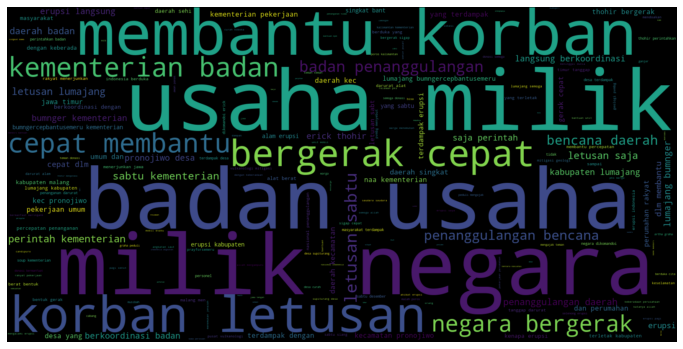

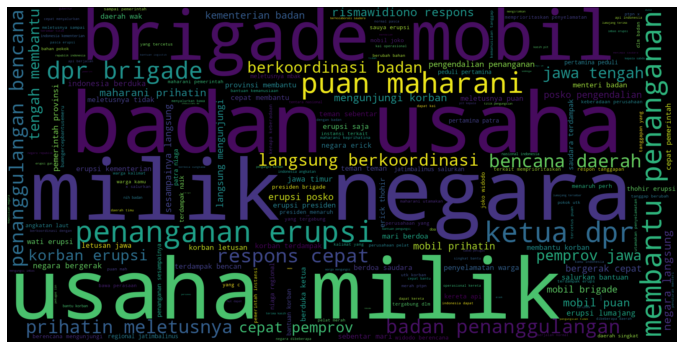

In [219]:
wordcloud_visualization(' '.join(isi_positif))
wordcloud_visualization(' '.join(isi_negatif))

Nilai rata-rata: 0.19394512771996217
Standar deviasi: 1.1917571076404576


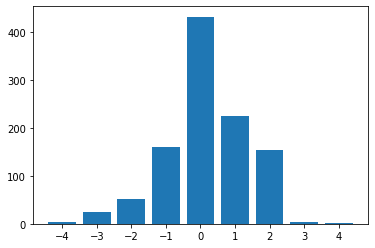

In [220]:
#lakukan analisis dan tarik kesimpulan dari Text analysis dan Sentiment Analysis
#masukkan analisis kalian pada sel berikut.

print ("Nilai rata-rata: "+str(np.mean(hasil)))
print ("Standar deviasi: "+str(np.std(hasil)))

labels, counts = np.unique(hasil, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

persebaran data seimbang antara sentimen positif dan sentimen negatif.

# 7. Network Analysis

Kita ingin melihat relasi kata terhadap kata lainnya.

In [221]:
data_gram = [word for tweet in df_semua["clean_berita"] for word in tweet.split()]
fdist = nltk.FreqDist(nltk.ngrams(data_gram, 2))
list_data = [[k,v]for k,v in fdist.items()]
df_bigram = pd.DataFrame(list_data, columns=['bigram', 'count'])
df_bigram_sort = df_bigram.sort_values(by=["count"], ascending=False).copy().reset_index(drop=True)
df_bigram_sort

bigram  count
0           (badan, usaha)    521
1           (usaha, milik)    521
2          (milik, negara)    521
3     (kementerian, badan)    377
4        (bergerak, cepat)    373
...                    ...    ...
2260       (sampai, ketua)      1
2261     (provinsi, ketua)      1
2262         (memi, ketua)      1
2263       (gunun, erupsi)      1
2264   (sekujur, tubuhnya)      1

[2265 rows x 2 columns]

In [222]:
d = df_bigram_sort.set_index("bigram").T.to_dict("records")

In [223]:
G = nx.Graph()

nodes_size = []
for k,v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v*10))

In [224]:
deg = dict(G.degree)

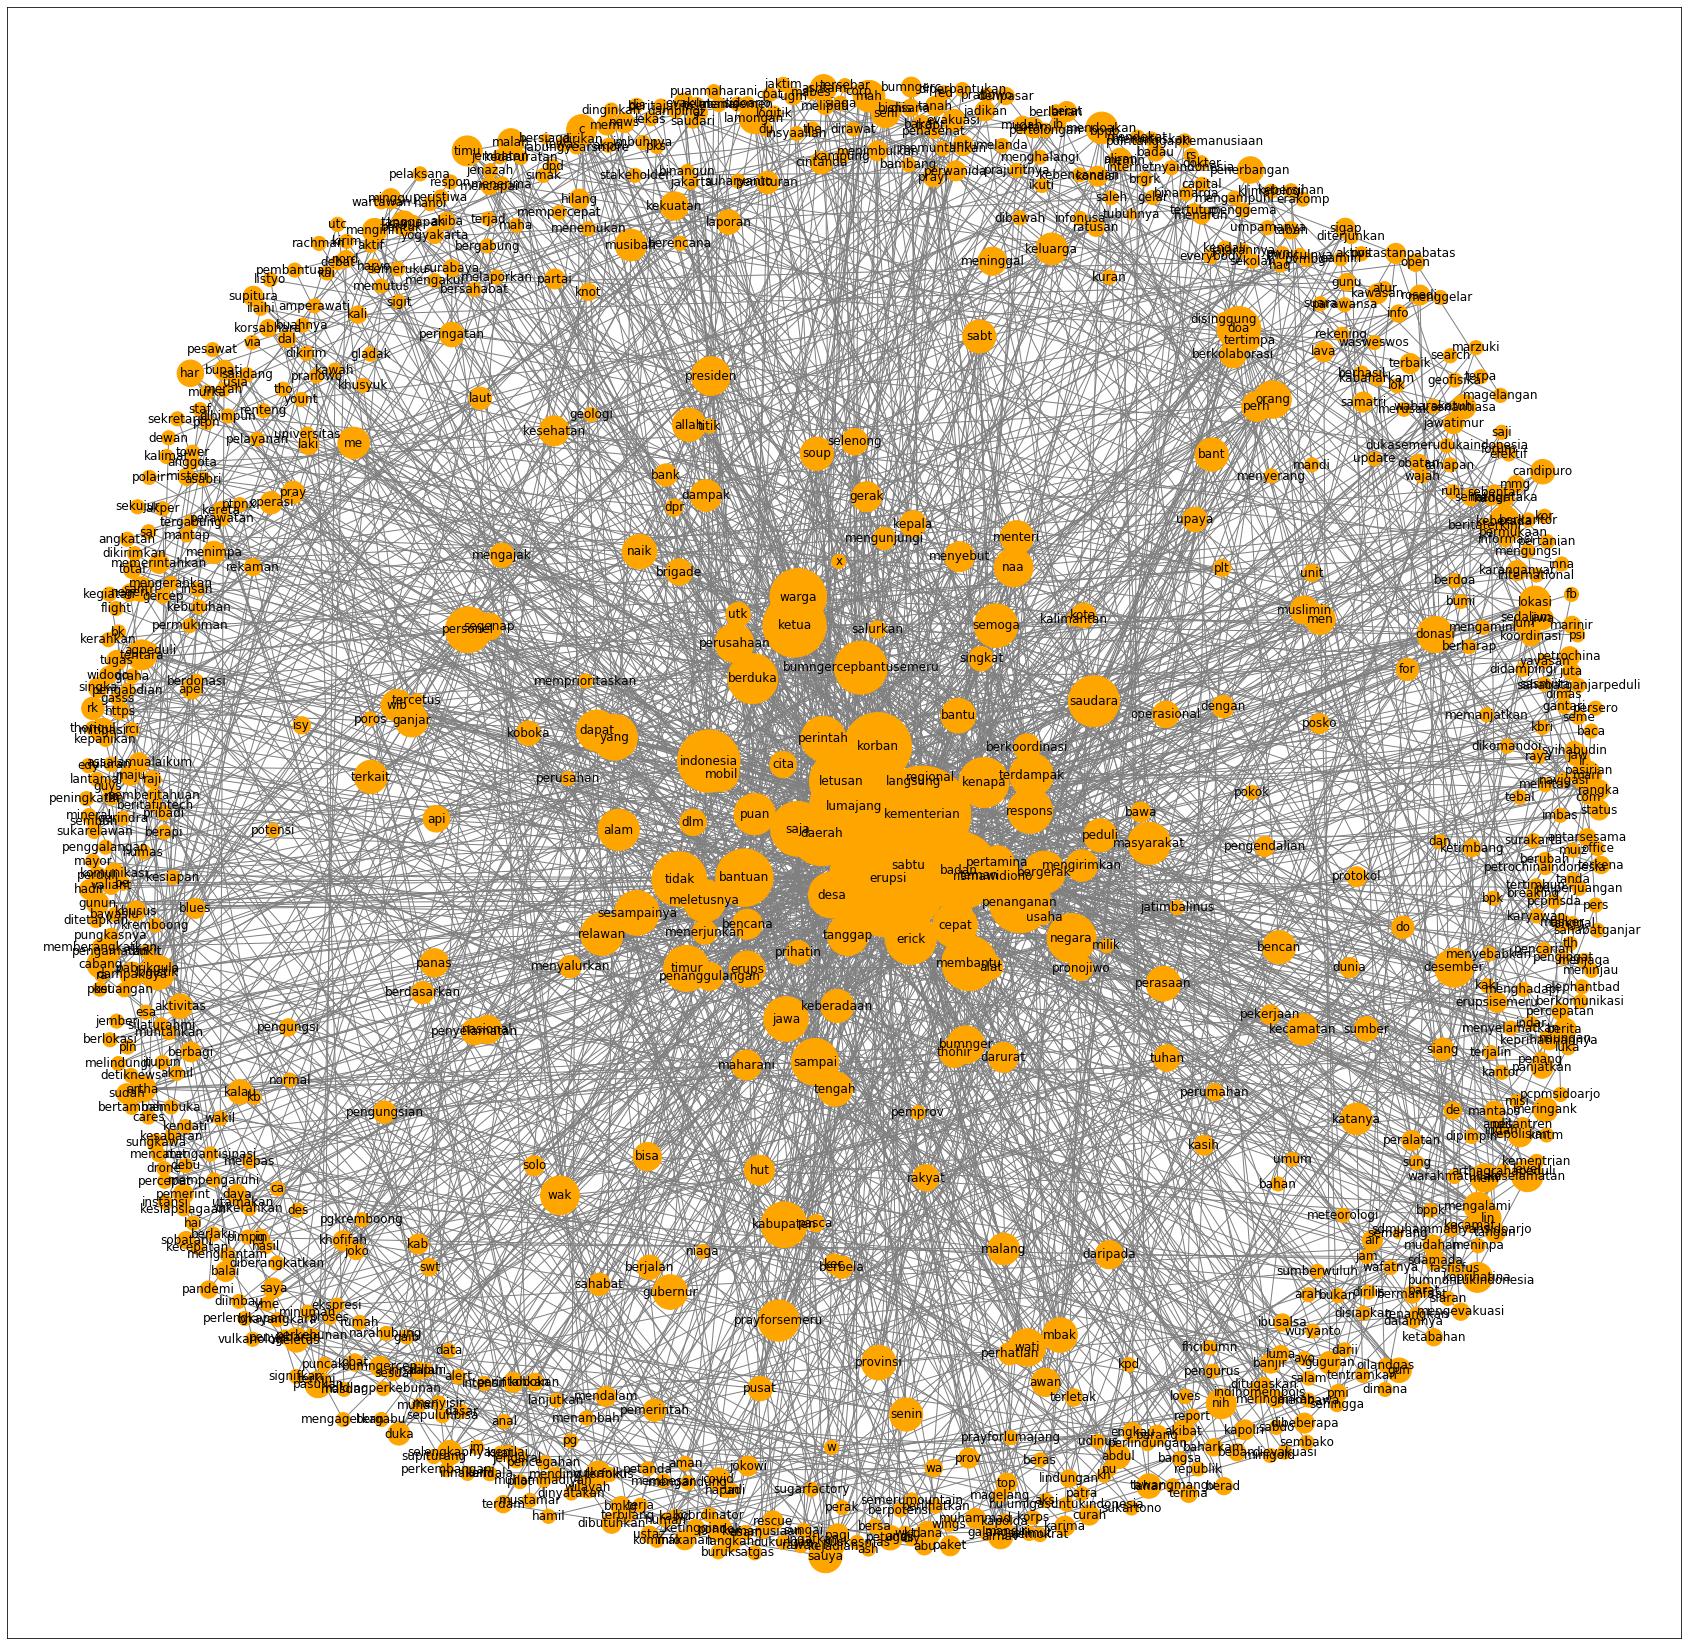

In [225]:
fig, ax = plt.subplots(figsize=(30, 30))
pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
        font_size=12,
        width=1,
        edge_color='grey',
        node_color='orange',
        with_labels = True,
        node_size = [v * 100 for v in deg.values()],
        ax=ax)  
plt.show()

Ternyata hasilnya masih terlalu ramai, untuk lebih detailnya lagi kita filter berdasarkan nilai degree > 30

In [226]:
deg_filter= G.degree()
items_filter = [n for n in deg_filter if n[1] > 30]

node = [node[0] for node in items_filter]
degree = [node[1]*20 for node in items_filter]

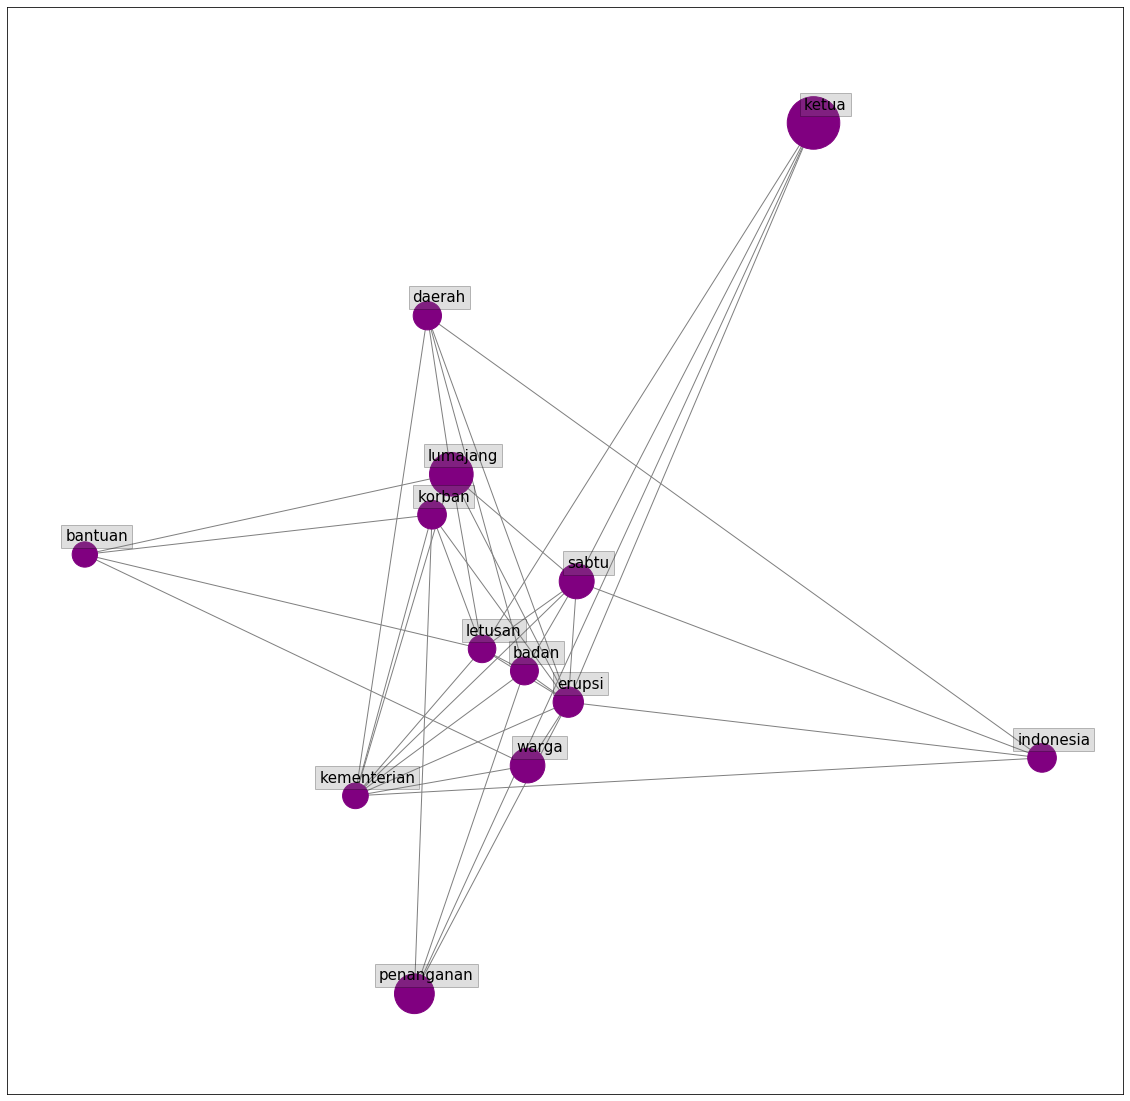

In [227]:
fig, ax = plt.subplots(figsize=(20, 20))

pos = nx.spring_layout(G, k=1.5)
k = G.subgraph(node)
print(k)

nx.draw_networkx(
    k, 
    pos=pos,
    font_size=14,
    font_color='white',
    width=1,
    edge_color='grey',
    node_color='purple',
    node_size = degree,
    with_labels= False,
    ax=ax
    )

# # Create offset labels
for key, value in pos.items():
      if key in node:
        x, y = value[0]+.005, value[1]+.005
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='grey', alpha=0.25),
                horizontalalignment='center', fontsize=15)

plt.show()

Pada graph terakhir kita bisa melihat relasi antar kata yang bigram dan degree nya memiliki nilai yang tinggi.